In [1]:
import sys
import os
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib
import toml
import time
from ipywidgets import *
import cv2
import uuid
from absl import logging
logging.set_verbosity(0)

import copy
import os
import json

from datetime import datetime

In [2]:
sys.path.append("/home/arindam/mules/mule/")
sys.path.append("/home/arindam/jupyter/")

In [3]:
from ati.perception.utils import quaternion_utils as qe
from ati.perception.lidar.lidar_pb import LidarSmallPb,LidarPb

In [4]:
#map_folder = "/home/arindam/mules/mule/IISC/"
# map_folder1 = "/atidata/customer/Bosch/map/bosch_16beam_v3/"
map_folder2 = "/home/arindam/data/map_exptls/"

In [5]:
# map_poses = np.load(map_folder + "/yelli_poses.npy")
# map_poses1 = np.load(map_folder1 + "/yelli_poses.npy")
# map_poses2 = np.load(map_folder2 + "/yelli_poses.npy")

In [6]:
# #%matplotlib notebook
# plt.figure(figsize =(7,7))
# plt.plot(map_poses[:,0], map_poses[:,1])
# plt.plot(map_poses1[:,0], map_poses1[:,1])
# plt.plot(map_poses2[:,0], map_poses2[:,1])

In [5]:
#dataset = "/atidata/customer/Bosch/2021-08-30-15-55-31-minimule-11-3-manual-Bosch-16beam_capture/"
#dataset = "/atidata/customer/Bosch/2021-08-30-16-24-40-minimule-11-3-manual-Bosch-32beam_capture_2/"
dataset = "/atidata/demo/comstar/2021-09-21-08-53-57-mini20-03-manual_comstar_mapping_run/"
dataset = "/atidata/customer/Flipkart_Malur_Impl/floor-Gplus2/2021-11-10-15-19-52-minimule-11-2-manual-FK_G_plus_2_MAPPING/"
dataset = "/atidata/customer/Flipkart_Malur_Impl/floor-Gplus1/2021-11-10-15-27-47-minimule-11-3-manual-FK_g+1_map_run/"
dataset = "/atidata/customer/Flipkart_Malur_Impl/floor-Gplus1-repeat-32beams/2021-11-11-15-31-42-minimule-11-2-manual-floor_1__mapping/"
#dataset = "/home/ati-support/BoschNov25/"

In [6]:
try:
    print("Small pb")
    spb = LidarSmallPb(dataset) 
except:
    spb = LidarPb(dataset)
print(spb.num_frames())
lidar_times = []
for i in range(spb.num_frames()):
    try:
        lidar_times.append(spb.get_frame(i)[0])
    except:
        lidar_times.append(np.nan)
        continue
lidar_times = np.array(lidar_times)

Small pb
27638


In [413]:
def imu_pose_estimate(imu_tracker, time, pose):
    dquat = imu_tracker.get_gyro_quaternion(time)
    dtheta = qe.get_roll_pitch_yaw_from_quaternion(dquat)[-1]
    pose_estimate = np.copy(pose)
    pose_estimate[2] += dtheta
    return pose_estimate


def select_best_pose(pose, scores):
    best = np.argmax(scores)
    best_theta = pose[best][2]
    best_theta = np.arctan2(np.sin(best_theta), np.cos(best_theta))
    pose[best][2] = best_theta
    return [pose[best]] * len(scores)


def get_prune_limits(grid_map, poses):
    cxmin, cymin = -grid_map.origin * grid.GRID_RES
    cxmax, cymax = (grid_map.grid.shape - grid_map.origin) * grid.GRID_RES
    xmin, xmax = (
        max(cxmin, np.min(poses[:, 0]) - map_padding),
        min(cxmax, np.max(poses[:, 0]) + map_padding),
    )
    ymin, ymax = (
        max(cymin, np.min(poses[:, 1]) - map_padding),
        min(cymax, np.max(poses[:, 1]) + map_padding),
    )
    ox, oy = grid_map.origin
    print(f"xlimit {(xmin, xmax)} ylimits {(ymin, ymax)}")
    print(f"origin {(ox, oy)}")
    grid_x_limit = (np.array([xmin, xmax]) / grid_res).astype("int") + ox
    grid_y_limit = (np.array([ymin, ymax]) / grid_res).astype("int") + oy
    print(f"grid_xlimit {grid_x_limit}, grid_ylimit {grid_y_limit}")
    return grid_x_limit, grid_y_limit

def plot_map(grid_map, alpha=1.0):
    x1, y1 = -grid_map.origin * grid_res
    x2, y2 = (grid_map.grid.shape - grid_map.origin) * grid_res
    if grid_map.grid.dtype == np.uint8:
        #max_val = min(255, np.max(grid_map.grid))
        max_val = 128
    else:
        max_val = 1
    plt.imshow(
        max_val - grid_map.grid.T,
        alpha=alpha,
        cmap="gray",
        origin="lower",
        extent=[x1, x2, y1, y2],
    )


# ### Loading data


def load_data(dir_path):
    imu_data = pd.read_csv(os.path.join(dir_path, "imu.csv"))
    # imu_data.gyro_z = np.deg2rad(imu_data.gyro_z)
    return imu_data

def prune_map(built_map, xlim, ylim):
    idown, iup = int(xlim[0]), int(xlim[1])
    jleft, jright = int(ylim[0]), int(ylim[1])
    ox, oy = built_map.maps[0].origin
    print(f"Grid coordinates: Cropping {[idown, iup, jleft, jright]}")
    pruned_map = copy.deepcopy(built_map)
    for i in range(len(pruned_map.beams)):
        pruned_map.maps[i].grid = pruned_map.maps[i].grid[
            idown : iup + 1, jleft : jright + 1
        ]
        pruned_map.maps[i].origin = np.asarray([ox - idown, oy - jleft]).astype(float)
    return pruned_map


def map_quality(grid_val, threshold=0.25):
    grid_vals = np.minimum(grid_val.flatten(), 0.99)
    mask = grid_vals > threshold
    entropy = np.average(-grid_vals[mask] * np.log2(grid_vals[mask]))
    return (1 - entropy) * 100


def generate_map_metadata(run_dir):
    run_meta_path = os.path.join(run_dir, "run_metadata.json")

    if os.path.isfile(run_meta_path):
        with open(run_meta_path, 'r') as f:
            run_meta = json.load(f)
    else:
        run_meta = {}

    return {
        "map_id": "map:" + str(uuid.uuid4()),
        "run_id": run_meta.get("run_id", "<unknown>"),
        "run_dir": run_dir,
        "generated_at": time.time(),
        "generated_at_friendly": datetime.now().isoformat(),
    }

def plot_map_new(grid_map, alpha=1.0):
    x1, y1 = -grid_map.origin * grid_map.grid_res
    x2, y2 = (grid_map.grid.shape - grid_map.origin) * grid_map.grid_res
    if grid_map.grid.dtype == np.uint8:
        max_val = 128
    else:
        max_val = 1
#     plt.imshow(
#         max_val - grid_map.grid.T,
#         alpha=alpha,
#         cmap="gray",
#         origin="lower",
#         extent=[x1, x2, y1, y2],
#     )
    plt.imshow(
        1 - (grid_map.grid.T>0),
        alpha=alpha,
        cmap="gray",
        origin="lower",
        extent=[x1, x2, y1, y2],
    )



def circular_sub(a1,a2):
    result = 0
    result = a1 - a2
    result = (result+ np.pi)%(2*np.pi) - np.pi    
    return result

In [8]:
from ati.perception.lidar import lidar_pb, lidar_utils
from ati.perception.lidar.lidar_voxel import voxel_filter
from ati.perception.utils.voxel_filter_utils import voxel_filter_fast
from ati.perception.lidar.lidar_frame import *
from ati.slam.yelli import utils, grid
from utils.imu_tracker import ImuTracker

data [0.1 0.6 0.1 0.6 1.  0.1 0.  0.6 0.6 0.3 0.4 0.5 0.3 0.1 0.8]
unique [0.  0.1 0.3 0.4 0.5 0.6 0.8 1. ]
sorted [0.  0.1 0.1 0.1 0.1 0.3 0.3 0.4 0.5 0.6 0.6 0.6 0.6 0.8 1. ]
indices of unique values [ 0  1  5  7  8  9 13 14]
argsort [ 6  0  2  5 13  9 12 10 11  1  3  7  8 14  4]


In [10]:
lidar_heights = {"tug": 0.825, "p20": 0.9, "p17": 0.9, "mini": 0.55, "mini20": 0.729}
map_name = "/home/arindam/data/map_exptls/"
imu_ts = [0.00667, 0.01]
data_dir = dataset
model = 'tug'
zmin = 0.3; zmax = 3.5
tilt = 0
alpha= 1.05
start_frame = 50
use_16_beams = False
max_frames = 30000
correct_roll_pitch = False

grid_params = {
    "x": (-0.1, 0.1),
#    "x": (-0.2, 0.2),
#    "x": (-0.4, 0.4),
#    "y": (-0.02, 0.30),
    "y": (-0.20, 0.30),
#    "y": (-0.40, 0.60),
    "theta": (-0.2, 0.2),
    "num_x": 11,
#    "num_x": 22,
#    "num_x": 44,
#    "num_y": 17,
    "num_y" : 26,
#    "num_y" : 52,
#    "num_t": 41,
    "num_t": 50,
    
}
grid_res = 0.02
pruned = True
map_padding = 15
web_map_padding = 5.0
save_as_float = True

try:
    import cupy

    use_cuda = True
except:
    use_cuda = False


In [13]:

roll = 0.0
pitch = 0.0
model = model.lower()
if model not in lidar_heights:
    print(
        f"Invalid sherpa model {model}. Model must be one of { sorted(list(lidar_heights.keys())) }"
    )
    raise Exception
lidar_ht = lidar_heights[model]
print(f"Model {model}, Lidar height = {lidar_ht:0.3f}")

if not os.path.exists(map_name):
    os.makedirs(map_name)

imu_data = load_data(data_dir)
ts = np.mean(np.diff(imu_data.time))
dt = imu_ts[np.argmin(np.abs(imu_ts - ts))]
#imu_tracker = ImuTracker(dt)
imu_tracker = ImuTracker()
imu_bias_initialized = False
i = 0
print(f"")
while not imu_bias_initialized:
    imu_bias_initialized = imu_tracker.get_initial_gyro_bias(imu_data.iloc[i])
    i += 1

best_scores, poses, frame_list = [], [], []

z_slices = [(zmin,zmax)]
print("Using Z slices:", z_slices)

pose = np.array([[0, 0, np.pi / 2 + tilt]] * len(z_slices))
prev_pose = pose.copy()
multimap = grid.MultiGrid(
    beams=z_slices, grid_alpha=alpha, slice_z=True, localize=False
)
# multimap = grid.MultiGrid(
#     beams=z_slices, grid_alpha=alpha, slice_z=True, localize=True
# )
i, frame_id = 0, -1
debug_data_dir = data_dir
bootstrap_frames =20
try:
    lpb = lidar_pb.LidarSmallPb(data_dir)
except:
    lpb = lidar_pb.LidarPb(data_dir)
prev_frame_time, prev_frame = lpb.get_frame(start_frame - 2)

if use_16_beams:
    if prev_frame.shape[0] == 32768:
        print("data has 16 beams only")
        use_16_beams = False
    else:
        print("using 16 beams only")

num_frames = np.minimum(len(lpb.list_frames()), max_frames)
print(f"total frames {num_frames}")
filtered_pts = []
for frame_id in range(start_frame, num_frames - 1):
    #if frame_id % 2 != 0:
    #    continue
    try:
        frame_time, frame = lpb.get_frame(frame_id)
    except:
        print(f"skipping {frame_id}. divide-by-zero error")
        continue

    frame = np.copy(frame[:, :6]).astype(np.float64)
    if use_16_beams:
        ##### fix for 32 beams
        frame = frame.reshape(-1,2048,6)
        if frame.shape[0] == 32:
            # select any 16 beams
            beams = [1,3,5,7,9,11,13,15,17,19,21,23,25,27,29,31]
            frame = frame[beams]
        frame = frame.reshape(-1,6)
        ##### fix for 32 beams

    if correct_roll_pitch:
        frame, roll, pitch = lidar_utils.correct_tilt(
            frame, roll, pitch, lidar_ht=lidar_ht, use_cuda=use_cuda
        )
        if abs(roll) > 0.05 or abs(pitch) > 0.05:
            print(f"Warning: Roll {roll:.2f}, Pitch  {pitch:0.2f}")

    #filtered_frame = voxel_filter(frame, voxel_size=0.05)
    filtered_frame,_ = voxel_filter_fast(voxel_filter(frame, voxel_size=0.05), trunc=False, voxel = 0.5)
    filtered_frame_z = multimap.split_frame(filtered_frame)
    
    frame_z = multimap.split_frame(voxel_filter(frame, voxel_size=0.05))

    
    filtered_pts.append(filtered_frame_z[0].shape[0])
    if frame_id < start_frame + bootstrap_frames:
        multimap.insert_points(filtered_frame_z, pose[0])
        frame_list.append(frame_id)
        poses.append(pose)
        prev_insert_ts = frame_time
        prev_frame_time, prev_frame = frame_time, frame
        continue

    relevant_imu_data = imu_data[imu_data["time"].between(prev_frame_time, frame_time)]
    for imu_idx in range(relevant_imu_data.shape[0]):
        imu_tracker.add_imu_data(relevant_imu_data.iloc[imu_idx])

    pose_estimate = imu_pose_estimate(imu_tracker, frame_time, pose[0])
    #print(frame_id,pose_estimate)
    search_space = utils.grid_space(center=pose_estimate, **grid_params)
    scores = multimap.search(filtered_frame_z, search_space)
    best = np.argmax(scores, axis=1)
    pose = [search_space[b] for b in best]
    best_scores.append([scores[i][b] for i, b in enumerate(best)])
    pose = select_best_pose(pose, best_scores[-1])
    #print(pose)
    if (np.linalg.norm(pose[0][:2]-prev_insert_pose[0][:2])> 0.1 or (prev_insert_ts - frame_time)>1) :
        #multimap.insert_points(filtered_frame_z, pose[0])
        multimap.insert_points(frame_z, pose[0])
        prev_insert_ts = frame_time
        prev_insert_pose = pose
    #multimap.insert_points(filtered_frame_z, pose[0])
     
    prev_pose = pose.copy()
    frame_list.append(frame_id)    
    poses.append(pose)
    if frame_id % 250 == 0:
        print(
            f"frame:{frame_id} scores:{best_scores[-1]} best pose:{pose[0]} size:{filtered_frame_z[0].shape[0]} "
        )
    prev_frame_time, prev_frame = frame_time, frame

multimap.transform_scores()
poses = np.array(poses)[:, 0, :].reshape(-1, 3)
print(f"final pose {poses[-1]}")
print(f"Min points in frame: {np.min(filtered_pts)}")
if pruned:
    print("Pruning the map..")
    grid_x_limit, grid_y_limit = get_prune_limits(multimap.maps[0], poses)
    multimap = prune_map(multimap, grid_x_limit, grid_y_limit)
if not save_as_float:
    multimap.maps[0].grid = (multimap.maps[0].grid * 128).astype(np.uint8)
    multimap.maps[0].origin.dtype = "float"
multimap.save_map(map_name)
np.save(f"{map_name}/yelli_poses.npy", poses)
np.save(f"{map_name}/yelli_frames.npy", frame_list)
with open(os.path.join(map_name, "map_metadata.json"), "w") as f:
    json.dump(generate_map_metadata(data_dir), f)
quality = map_quality(multimap.maps[0].grid)
print(f"map quality {quality}")
alpha_arr = [1.0, 0.7]



Model tug, Lidar height = 0.825

Using Z slices: [(0.3, 3.5)]
total frames 30000


/home/arindam/myvenv/venv375/lib/python3.7/site-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)


NameError: name 'prev_insert_pose' is not defined

In [ ]:
poses = np.array(poses)[:, 0, :].reshape(-1, 3)

In [ ]:
%matplotlib notebook

alpha_arr = [1.0, 0.7]
plt.figure(figsize=(6, 6))
for i in range(len(multimap.beams)):
    plot_map(multimap.maps[i], alpha=alpha_arr[i])
x, y, t = np.array(poses).T
plt.plot(x, y, "ro-", ms=1)
plt.grid()
plt.axis("equal")
xf, yf, tf = poses[-1]
#plt.title(
#    f"{map_name} frames:{num_frames} Qual:{quality:0.1f} final:{xf:0.2f} {yf:0.2f} {tf:0.3f}"
#)
plt.savefig(f"{map_name}/yelli_map.png", dpi=1000, bbox_inches="tight")
print("Generating webui map and json...")
#mule_root = os.getenv("ATI_MULE_ROOT")
#genwebpath = mule_root + "/utils/" + "generate_web_map.py"
print("Generating webui map and json...")
#mule_root = os.getenv("ATI_MULE_ROOT")
#genwebpath = mule_root + "/utils/" + "generate_web_map.py"
genwebpath = "home/arindam/mules/mule/utils/" + "generate_web_map.py"
os.system(f"python3 generate_web_map.py {map_name} --padding {web_map_padding}")
os.system(f"python3 {genwebpath} {map_name} --padding {web_map_padding}")
print(f"Finished generating map. Results in ./{map_name}")


In [19]:

print("Generating webui map and json...")
#mule_root = os.getenv("ATI_MULE_ROOT")
#genwebpath = mule_root + "/utils/" + "generate_web_map.py"
genwebpath = "home/arindam/mules/mule/utils/" + "generate_web_map.py"
os.system(f"python3 generate_web_map.py {map_name} --padding {web_map_padding}")
os.system(f"python3 {genwebpath} {map_name} --padding {web_map_padding}")
print(f"Finished generating map. Results in ./{map_name}")
web_map_padding

Generating webui map and json...
Finished generating map. Results in .//home/arindam/data/map_exptls/


5.0

In [24]:
from utils.generate_web_map import generate_map
generate_map(map_name, padding=web_map_padding)

TypeError: __init__() got an unexpected keyword argument 'padding'

In [52]:
len(frame_list), len(poses)

(42, 42)

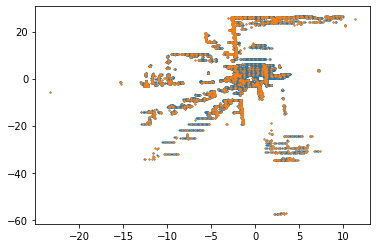

In [25]:
#fr,ts = lpb.get_frame(frame_id)
vfr, vinds =voxel_filter_fast(frame, trunc=False, voxel = 0.5)

plt.figure()
plt.scatter(frame[:,0], frame[:,1], s=1)
plt.scatter(vfr[:,0], vfr[:,1], s=1)

(-24.972062158584595,
 13.049680757522584,
 -61.71600656509399,
 30.694821643829346)

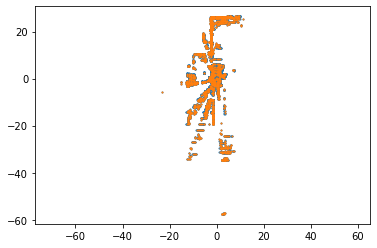

In [26]:
vf = (frame[:,:3]//0.5).astype(np.uint16).astype(np.uint64)
v = (vf[:,0]<<32) + (vf[:,1] << 16) + vf[:,2] 
uv,uv_inds = np.unique(v, return_index=True) 

vfr = frame[uv_inds]
plt.figure()
plt.scatter(frame[:,0], frame[:,1], s=1)
plt.scatter(vfr[:,0], vfr[:,1], s=1)
plt.axis('equal')

In [11]:
from numba import jit

SliceHeight = 0.2
MinDistance = 0.2
MaxDistance = 0.9
def compute_slice(pointcloud, slice_height):
    zs = (pointcloud[:,2]//slice_height).astype(int)
    z_unique = np.unique(zs)
    slices = [pointcloud[zs == z] for z in z_unique]
    return z_unique, slices

def sort_slice(z_slice, min_distance):
    centroid = z_slice[:,:3].mean(axis = 0)
    delta = z_slice[:,:2] - centroid[:2]
    delta_mindist_inds = np.linalg.norm(delta, axis = 1) > min_distance
    delta = delta[delta_mindist_inds]
    z_slice = z_slice[delta_mindist_inds]
    angles = np.arctan2(delta[:,0], delta[:,1])
    sort_inds = np.argsort(angles)
    return z_slice[sort_inds]

@jit(nopython = True)
def add_value_to_histogram(angle, value, histogram):
    #map angle to 0,np.pi, thus a vector and its inverse (-ve) are the same
    while angle > np.pi:
        angle = angle -np.pi
    while angle < 0:
        angle = angle + np.pi
    norm_angle = angle / np.pi
    bucket_id = np.int(norm_angle * histogram.shape[0] - 0.5)
    if bucket_id < 0:
        bucket_id = 0
    elif bucket_id > histogram.shape[0] -1:
        bucket_id = histogram.shape[0] -1
                       
    histogram[bucket_id] += value
    return histogram

@jit(nopython= True)
def add_pointcloud_slice_to_histogram(z_slice, histogram, min_dist, max_dist):
    if len(z_slice) == 0: 
        return histogram
    centroid = np.array([np.sum(z_slice[:,0]),np.sum(z_slice[:,1]), np.sum(z_slice[:,2])])/len(z_slice)
    direction = z_slice[:,:2] - centroid[:2]
    last_position= z_slice[0]
    for i in range(len(z_slice)):
        delta = z_slice[i][:2] - last_position[:2]
        distance = np.linalg.norm(delta[:2])
        if (distance < min_dist) or (np.linalg.norm(direction[i]) < min_dist):
            continue
        if (distance > max_dist):
            last_position = z_slice[i]
            continue
        angle = np.arctan2(delta[0], delta[1])
        value = max(0, 1 - np.fabs(np.dot(delta/np.linalg.norm(delta), 
                                          direction[i]/np.linalg.norm(direction[i]))))
        histogram = add_value_to_histogram(angle, value, histogram)
        
    return histogram
        
@jit(nopython = True)
def match_histograms(hist1, hist2):
    hist1_norm = np.linalg.norm(hist1)
    hist2_norm = np.linalg.norm(hist2)
    norm = hist1_norm * hist2_norm
    if norm < 1e-3:
        return 1
    return np.dot(hist1,hist2)/norm

@jit(nopython = True)
def rotate_histogram(histogram, angle):
    rotate_by_buckets = -angle * histogram.shape[0]/np.pi
    full_buckets = int(rotate_by_buckets - 0.5)
    fraction = rotate_by_buckets - full_buckets
    while (full_buckets < 0):
        full_buckets = full_buckets + histogram.shape[0]
        
    rotated_hist1 = np.zeros(histogram.shape)
    rotated_hist2 = np.zeros(histogram.shape)
    hist_inds = np.arange(histogram.shape[0])
    rotated_hist1 = histogram[(hist_inds + full_buckets ) % histogram.shape[0]]
    rotated_hist2 = histogram[(hist_inds +1+ full_buckets ) % histogram.shape[0]]
    return fraction * rotated_hist1 + (1-fraction) * rotated_hist2

@jit(nopython = True)
def find_match_estimates(histogram1, histogram2, initial_angle, angles):
    estimates = np.zeros(angles.shape[0])
    for i in range(len(angles)):
        angle = angles[i]
        rotated_histogram1 = rotate_histogram(histogram1, initial_angle + angle)
        estimates[i] = match_histograms(histogram2, rotated_histogram1)
    return estimates

In [155]:
hist_size = 120
frame_id = 100
ts, fr = lpb.get_frame(frame_id)
pts = fr[fr[:,4]>0][:,:3]
z_unique, zslices = compute_slice(pts, SliceHeight)
#zslice = zslices[9]
#sorted_slice = sort_slice(zslice, MinDistance)
histogram = np.zeros(120)
h1 = np.zeros(hist_size)
h2 = np.zeros(hist_size)
#h1 = add_pointcloud_slice_to_histogram(sorted_slice, h1, MinDistance, MaxDistance)
#h2 = add_pointcloud_slice_to_histogram(sorted_slice, h1, MinDistance, MaxDistance)

for zi in range(len(zslices)):
    #print("zi",zi)
    zslice = zslices[zi]
    h1 = add_pointcloud_slice_to_histogram(sort_slice(zslice, MinDistance), h1, MinDistance, MaxDistance)


In [157]:
#h3 = rotate_histogram(h1, np.pi/3)
frame_id = 4200
ts, fr = lpb.get_frame(frame_id)
pts = fr[fr[:,4]>0][:,:3]
z_unique, zslices= compute_slice(pts,  SliceHeight)
h3 = np.zeros(hist_size)
for zslice in zslices:
    h3 = add_pointcloud_slice_to_histogram(sort_slice(zslice, MinDistance), h3, MinDistance, MaxDistance)
match_histograms(h1, h3)

0.5197195994011117

In [65]:
angles = np.linspace(0.01,np.pi, 100)
initial_angle = 0
est = find_match_estimates(h1, h3, initial_angle, angles)
ind = np.argmax(est)
angles[ind], np.pi/3

(1.0538642178632645, 1.0471975511965976)

<IPython.core.display.Javascript object>


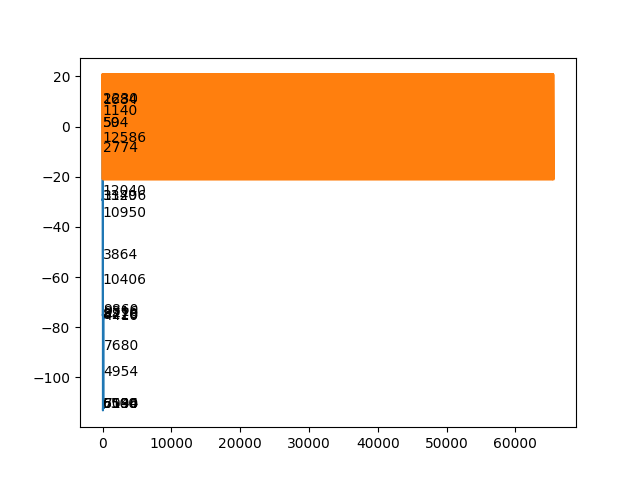

0
272
545
817
1090
1362
1635
1907
2180
2452
2725
2997
3270
3543
3815
4088
4360
4633
4905
5178
5450
5723
5995
6268
6541


IndexError: index 6541 is out of bounds for axis 0 with size 6541

In [78]:
num_poses = len(poses)
ils = np.linspace(0,num_poses,25, dtype='int')
plt.figure()
plt.plot(poses[:,0], poses[:,1])
for il in ils:
    print(il)
    plt.text(poses[il,0], poses[il,1], str(frame_list[il]))

In [160]:
from numba_grid import Prob_Grid_numba

data [0.1 0.1 0.5 0.1 0.1 0.4 0.5 0.6 0.4 1.  0.5 0.9 0.1 0.7 0.7]
unique [0.1 0.4 0.5 0.6 0.7 0.9 1. ]
sorted [0.1 0.1 0.1 0.1 0.1 0.4 0.4 0.5 0.5 0.5 0.6 0.7 0.7 0.9 1. ]
indices of unique values [ 0  5  7 10 11 13 14]
argsort [ 0  1  3  4 12  5  8  2  6 10  7 13 14 11  9]


In [165]:
fr_id = 60
ts, fr = lpb.get_frame(fr_id)

fr = fr[fr[:,4]>0]
fr = fr[(fr[:,2] > zmin) & (fr[:,2] < zmax)]
fr = np.copy(fr[:, :6]).astype(np.float64)
fr = voxel_filter(fr[:,:3], voxel_size = 0.05 )



(14956, 6)


In [26]:
import zstandard as zstd


In [9]:
import numba

GRID_START_SIZE = (128, 128)
GRID_RESIZE = 1.5
GRID_RES = 0.02

GRID_START_VALUE = 0.0

class Grid2D:
    def __init__(self, grid_alpha=1, grid_res = GRID_RES):
        self.grid = np.full(GRID_START_SIZE, GRID_START_VALUE, dtype=np.uint8)
        self.origin = np.zeros(2)
        self.grid_alpha = grid_alpha
        self.grid_res = grid_res
        

    def set_grid(self, grid):
        self.grid = grid

    def _resize_map(self, origin_shift, new_size):
        old_grid, self.grid = self.grid, np.full(new_size, GRID_START_VALUE, dtype=self.grid.dtype)
        (sx, sy), (ex, ey) = origin_shift, old_grid.shape
        self.grid[sx : sx + ex, sy : sy + ey] = old_grid
        self.origin += origin_shift

    def _maybe_resize_map(self, frame):
        lower, upper = np.min(frame, axis=0), np.max(frame, axis=0)

        if np.any(lower < 0) or np.any(upper >= self.grid.shape):
            origin_shift = -np.minimum(lower, 0)
            origin_shift = origin_shift + (origin_shift != 0) * (
                np.array(self.grid.shape) * (GRID_RESIZE - 1)
            )
            new_size = np.maximum(self.grid.shape, upper * GRID_RESIZE) + origin_shift

            origin_shift, new_size = (
                origin_shift.astype(np.int32),
                new_size.astype(np.int32),
            )

            self._resize_map(origin_shift, new_size)
            return True
        return False

    def transform_world_to_grid(self, frame):
        return frame / self.grid_res + self.origin

    def transform_local_to_grid(self, frame, pose):
        frame_xy = frame[:, :-1]
        frame_xy = utils.transform_local_to_world(pose, frame_xy)
        frame_xy = self.transform_world_to_grid(frame_xy).astype(np.int32)
        return frame_xy
    
    def insert_points(self, pose, frame):
        """Insert 2D frame into map"""
        if frame.shape[0] == 0:
            return
        frame_xy = self.transform_local_to_grid(frame, pose)
        if self._maybe_resize_map(frame_xy):
            frame_xy = self.transform_local_to_grid(frame, pose)
        x, y = frame_xy.T
        self.grid[x, y] = np.minimum(self.grid[x, y] + self.grid_alpha, 255)

    def search(self, frame, search_space, count_once=False):
        """Score of poses in search_space. Frame must be in local coordinates"""
        if not count_once:
            return search_fastv2(self.grid, self.origin, search_space, frame, self.grid_res)
        else:
            return search_fast_count_once(self.grid, self.origin, search_space, frame, self.grid_res)

    def apply_median_filter(self, kernel_size):
        self.grid = scipy.ndimage.median_filter(self.grid, kernel_size)

    def linear_transform(self, t1=3, t2=20):
        self.grid[self.grid < t1] = 0
        self.grid[self.grid > t2] = t2
        
        
@numba.njit(fastmath=True, parallel=True)
def search_fastv2(grid, grid_origin, poses, frame, grid_res):
    scores = np.zeros(poses.shape[0])
    for i in numba.prange(poses.shape[0]):
        scores[i] = score_function(grid, grid_origin, poses[i, :], frame, grid_res)
    return scores

@numba.njit(fastmath=True, parallel=True)
def search_fast_count_once(grid, grid_origin, poses, frame, grid_res):
    scores = np.zeros(poses.shape[0])
    num_visited = np.zeros(poses.shape[0])
    for i in numba.prange(poses.shape[0]):
        scores[i], num_visited[i] = score_function_count_once(grid, grid_origin, poses[i, :], frame, grid_res)
    return scores, num_visited


@numba.njit(fastmath=True)
def score_function_count_once(grid, grid_origin, pose, frame, grid_res):
    """Score of frame in map. Frame must be in local coordinates."""
    score = 0

    px, py, ptheta = pose[0], pose[1], pose[2] - np.pi / 2
    c, s = np.cos(ptheta), np.sin(ptheta)
    visited = set()
    for i in range(frame.shape[0]):
        x, y, z = frame[i, 0], frame[i, 1], frame[i, 2]
        ix = int(((c * x - s * y) + px) / grid_res + grid_origin[0])
        iy = int(((s * x + c * y) + py) / grid_res + grid_origin[1])
        if (ix,iy) in visited:
            continue
        if (ix >= 0) and (ix < grid.shape[0]) and (iy >= 0) and (iy < grid.shape[1]):
            score += prob_from_odds(grid[ix, iy])
        visited.add((ix,iy))

    return score, len(visited)

@numba.njit(fastmath=True)
def score_function(grid, grid_origin, pose, frame, grid_res):
    """Score of frame in map. Frame must be in local coordinates."""
    score = 0

    px, py, ptheta = pose[0], pose[1], pose[2] - np.pi / 2
    c, s = np.cos(ptheta), np.sin(ptheta)

    for i in range(frame.shape[0]):
        x, y, z = frame[i, 0], frame[i, 1], frame[i, 2]
        ix = int(np.ceil(((c * x - s * y) + px) / grid_res + grid_origin[0]))
        iy = int(np.ceil(((s * x + c * y) + py) / grid_res + grid_origin[1]))
        
        if (ix >= 0) and (ix < grid.shape[0]) and (iy >= 0) and (iy < grid.shape[1]):
            score += grid[ix, iy]


    return score

@numba.jit(nopython = True)
def odds(probability):
    return probability/(1-probability)

@numba.jit(nopython = True)
def prob_from_odds(odds_val):
    return odds_val/(1+ odds_val)


#%timeit sc=search_fast_count_once(active_submaps[0].grid.grid, active_submaps[0].grid.origin, search_space, frame_z, active_submaps[0].grid.grid_res )
#sc/len(frame_z)

In [ ]:
g = Grid2D()
fr  

In [10]:
import pickle 
import zstandard

class Submap:
    def __init__(self, pose, grid_res, grid_alpha):
        self.pose = pose.copy()
        self.grid_alpha = grid_alpha
        self.grid_res = grid_res
        self.grid = Grid2D(self.grid_alpha, self.grid_res )
        self.num_insertions = 0
        self.finished = False
        self.node_ids = []
        self.frame_ids = []
        self.local_insertion_poses = None
        self.iscompressed = False
        
    def search(self, frame, search_space, count_once = True):
        return self.grid.search(frame, search_space, count_once=count_once)
    
    def insert_points(self, frame, pose, frame_id, node_id):        
        if not self.finished:
            self.num_insertions +=1
            self.grid.insert_points(pose, frame)
            self.node_ids.append(node_id)
            self.frame_ids.append(frame_id)
            if self.local_insertion_poses is None:
                self.local_insertion_poses = pose.reshape(1,3)
            else:
                self.local_insertion_poses = np.concatenate((self.local_insertion_poses, pose.reshape(1,3)), axis = 0)
        else:
            print("Submap update is finished. Not inserting ")
            
    def finish(self):
        self.finished = True
        self.compress_data()
    
    def compress_data(self):
        cctx = zstandard.ZstdCompressor()
        self.grid = pickle.dumps(self.grid)
        self.grid = cctx.compress(self.grid)
        self.iscompressed = True
        
    def decompress_data(self):
        dctx = zstandard.ZstdDecompressor()
        self.grid = dctx.decompress(self.grid)
        self.grid = pickle.loads(self.grid)
        self.iscompressed = False
        
        
        
def get_2D_rotation_mat(theta):
    cth = np.cos(theta)
    sth = np.sin(theta)
    return np.array([[cth, -sth],
                    [sth, cth]])

def get_angle_from_2D_rotation_mat(R):
    return np.arctan2(R[1,0], R[0,0])

def get_yelli_rotation(theta):
    th = theta - np.pi/2
    R = get_2D_rotation_mat(th)
    return R

def get_inverse_yelli_rotation(theta):
    return get_yelli_rotation(theta).T

def get_yelli_transform(pose):
    R = get_yelli_rotation(pose[2])
    t = pose[:2]
    return R,t

def get_inverse_yelli_transform(pose):
    R = get_inverse_yelli_rotation(pose[2])
    t = -R @ pose[:2].reshape(2,1)
    return R,t.flatten()

def normalize_pose(theta):
    theta = np.arctan2(np.sin(theta), np.cos(theta))
    return theta

def get_inverse_yelli_pose(pose):
    #theta = -pose[2] + np.pi
    #theta = normalize_pose(theta)
    R,t = get_inverse_yelli_transform(pose) 
    theta = get_angle_from_2D_rotation_mat(R) + np.pi/2 
    theta = normalize_pose(theta)
    return np.array([t[0], t[1], theta])



def combine_yelli_poses(p1, p2):
    R1,t1 = get_yelli_transform(p1)
    R2,t2 = get_yelli_transform(p2)
    R = R1 @ R2
    t = (t1.reshape(2,1) + R1 @ t2.reshape(2,1)).flatten()
    theta = get_angle_from_2D_rotation_mat(R) + np.pi/2
    theta = normalize_pose(theta)
    return np.array([t[0], t[1], theta])
    
def imu_submap_pose_estimate(imu_tracker, time, submap_pose, pose):
    spose = combine_yelli_poses(pose, get_inverse_yelli_pose(submap_pose))
    dquat = imu_tracker.get_gyro_quaternion(time)
    dtheta = qe.get_roll_pitch_yaw_from_quaternion(dquat)[-1]
    pose_estimate = np.copy(spose)
    pose_estimate[2] += dtheta
    return pose_estimate



In [176]:
a = np.array([0,1, np.pi/2])
b = np.array([0,1, np.pi/2+np.pi/3])
combine_yelli_poses(b, a)

array([-0.8660254 ,  1.5       ,  2.61799388])

In [177]:
get_2D_rotation_mat(np.pi/3) @ np.array([[0],[1]])

array([[-0.8660254],
       [ 0.5      ]])

In [11]:
get_angle_from_2D_rotation_mat(get_2D_rotation_mat(np.pi/2).T)

-1.5707963267948966

In [12]:
a = np.array([1.23,3,0])
b = np.array([1., 2, np.pi/2])
#combine_yelli_poses(a,combine_yelli_poses(a, get_inverse_yelli_pose(a)))'
combine_yelli_poses(b,a)
#get_inverse_yelli_pose(a),get_inverse_yelli_pose(b) 

array([2.23, 5.  , 0.  ])

In [13]:
imu_ts = [0.00667, 0.01]

f_range = 65
grid_res = 0.02
grid_alpha =1
num_submap_range_data = 90
alpha= 1.05
start_frame = 50

grid_params = {
    "x": (-0.1, 0.1),
#    "x": (-0.2, 0.2),
#    "x": (-0.4, 0.4),
#    "y": (-0.02, 0.30),
    "y": (-0.20, 0.30),
#    "y": (-0.40, 0.60),
    "theta": (-0.2, 0.2),
#    "num_x": 11,
#    "num_x": 22,
#    "num_x": 44,
#    "num_y": 17,
#    "num_y" : 26,
#    "num_y" : 52,
#    "num_t": 41,
    "num_t": 61,
    
}

grid_params['num_x'] = int((grid_params['x'][1] - grid_params['x'][0])/grid_res + 1)
grid_params['num_y'] = int((grid_params['y'][1] - grid_params['y'][0])/grid_res + 1)


zmin = 0.3
zmax = 2.0

In [14]:
try:
    print("Small pb")
    spb = LidarSmallPb(dataset) 
except:
    spb = LidarPb(dataset)
print(spb.num_frames())
lidar_times = []
for i in range(spb.num_frames()):
    try:
        lidar_times.append(spb.get_frame(i)[0])
    except:
        lidar_times.append(np.nan)
        continue
lidar_times = np.array(lidar_times)

Small pb
27638


Text(0.5, 0.98, '/atidata/customer/Flipkart_Malur_Impl/floor-Gplus1-repeat-32beams/2021-11-11-15-31-42-minimule-11-2-manual-floor_1__mapping/')

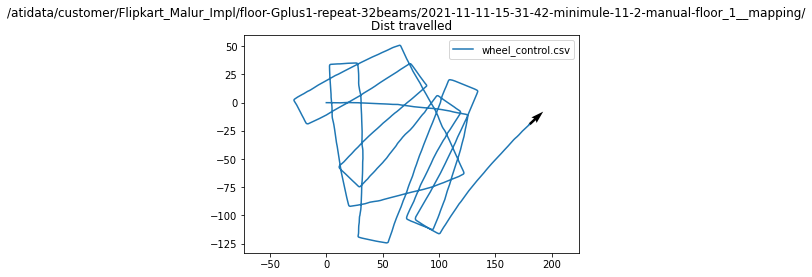

In [15]:
w_df = pd.read_csv(dataset + "/debug/wheel_control.csv")
all_w = w_df.w.values 
all_v = w_df.v.values
wtimes = w_df.time.values
lidar_wheel_inds = np.searchsorted(wtimes, lidar_times)
wheel_enc_ts = 0.01

ths = np.cumsum(all_w * wheel_enc_ts)
ds = all_v * wheel_enc_ts
xs = np.cumsum(ds * np.cos(ths))
ys = np.cumsum(ds * np.sin(ths))
plt.plot(xs, ys, label = "wheel_control.csv")
#plt.plot(lxs, lys, label = "low_level_control.csv")
plt.quiver(xs[-1], ys[-1], np.cos(ths[-1]), np.sin(ths[-1]))
plt.axis('equal')
plt.legend()
plt.title("Dist travelled")
plt.suptitle(dataset)

In [16]:
def check_vehicle_motion(wheel_enc):
    v_thresh, w_thresh = 0.1, 0.02
    if len(wheel_enc) == 0:
        return False, 0, 0
    v, w = np.mean(np.abs(wheel_enc),axis=0)
    return (v >= v_thresh) or (w >= w_thresh), v, w

In [17]:
(grid_params['x'][1] - grid_params['x'][0])/grid_res
0.4/(grid_res/f_range), 0.4/50

(1300.0, 0.008)

In [18]:
max_frames = 75000 
data_dir = dataset
imu_data = load_data(data_dir)
ts = np.mean(np.diff(imu_data.time))
dt = imu_ts[np.argmin(np.abs(imu_ts - ts))]
#imu_tracker = ImuTracker(dt)
imu_tracker = ImuTracker()
imu_bias_initialized = False
i = 0
print(f"")
while not imu_bias_initialized:
    imu_bias_initialized = imu_tracker.get_initial_gyro_bias(imu_data.iloc[i])
    i += 1
best_scores, poses, frame_list = [], [], []
submaps = []

z_slices = [(zmin,zmax)]

print("Using Z slices:", z_slices)

#pose = np.array([[0, 0, np.pi / 2 + tilt]] * len(z_slices))
pose = np.array([0.,0., np.pi/2])
prev_pose = pose.copy()

active_submaps = []
finished_submaps = []

spose = pose
#spose = np.array([1,2,0])
submap = Submap(spose.copy(), grid_res, grid_alpha)
active_submaps.append(submap)

node_poses = []
insertion_fr_ids=[]

count_once = True

i, frame_id = 0, -1
debug_data_dir = data_dir
bootstrap_frames =20
try:
    lpb = lidar_pb.LidarSmallPb(data_dir)
except:
    lpb = lidar_pb.LidarPb(data_dir)
prev_frame_time, prev_frame = lpb.get_frame(start_frame - 2)

# if use_16_beams:
#     if prev_frame.shape[0] == 32768:
#         print("data has 16 beams only")
#         use_16_beams = False
#     else:
#         print("using 16 beams only")

num_frames = np.minimum(len(lpb.list_frames()), max_frames)
print(f"total frames {num_frames}")
filtered_pts = []
for frame_id in range(start_frame, num_frames - 1):
    #if frame_id % 2 != 0:
        #continue
    try:
        frame_time, frame = lpb.get_frame(frame_id)
    except:
        print(f"skipping {frame_id}. divide-by-zero error")
        continue

    frame = np.copy(frame[:, :6]).astype(np.float64)
#     if use_16_beams:
#         ##### fix for 32 beams
#         frame = frame.reshape(-1,2048,6)
#         if frame.shape[0] == 32:
#             # select any 16 beams
#             beams = [1,3,5,7,9,11,13,15,17,19,21,23,25,27,29,31]
#             frame = frame[beams]
#         frame = frame.reshape(-1,6)
#         ##### fix for 32 beams

#     if correct_roll_pitch:
#         frame, roll, pitch = lidar_utils.correct_tilt(
#             frame, roll, pitch, lidar_ht=lidar_ht, use_cuda=use_cuda
#         )
#         if abs(roll) > 0.05 or abs(pitch) > 0.05:
#             print(f"Warning: Roll {roll:.2f}, Pitch  {pitch:0.2f}")

    frame = frame[(frame[:,4]>0) & (frame[:,4] < 60)]
    frame = frame[(frame[:,2] > zmin) & (frame[:,2] < zmax)]
    
    #filtered_frame = voxel_filter(frame, voxel_size=0.05)
    filtered_frame,_ = voxel_filter_fast(voxel_filter(frame, voxel_size=0.05), trunc=False, voxel = 0.25)
    #filtered_frame_z = multimap.split_frame(filtered_frame)
    
    frame_z = voxel_filter(frame[:,:3], voxel_size=0.05)

    
    #filtered_pts.append(filtered_frame_z[0].shape[0])

    if frame_id < start_frame + bootstrap_frames:
        #multimap.insert_points(filtered_frame_z, pose[0])
        #print("pose", pose, frame_z.shape)
        print("Num Bootstrap insertions", active_submaps[0].num_insertions)
        spose = combine_yelli_poses(pose, get_inverse_yelli_pose(active_submaps[0].pose))
        node_poses.append(pose)
        insertion_fr_ids.append(frame_id)
        active_submaps[0].insert_points(frame_z, spose, frame_id, node_id = len(node_poses)-1 )
        frame_list.append(frame_id)
        poses.append(pose)
        prev_insert_ts = frame_time
        prev_frame_time, prev_frame = frame_time, frame
        last_inserted_pose = pose.copy()
        continue
    
    prev_wid = lidar_wheel_inds[frame_id-1]
    present_wid = lidar_wheel_inds[frame_id]
    is_moving, v, w = check_vehicle_motion(np.vstack((all_v[prev_wid:present_wid],all_w[prev_wid:present_wid])).T)
        
    if not is_moving:
        continue
    
    relevant_imu_data = imu_data[imu_data["time"].between(prev_frame_time, frame_time)]
    for imu_idx in range(relevant_imu_data.shape[0]):
        imu_tracker.add_imu_data(relevant_imu_data.iloc[imu_idx])

    pose_estimate = imu_pose_estimate(imu_tracker, frame_time, pose)
    spose_estimate = combine_yelli_poses(get_inverse_yelli_pose(active_submaps[0].pose),pose_estimate)
    #spose_estimate = imu_submap_pose_estimate(imu_tracker, frame_time, active_submaps[0].pose, pose)
    #print(frame_id,pose_estimate)
    search_space = utils.grid_space(center=spose_estimate, **grid_params)
    #scores = multimap.search(filtered_frame_z, search_space)
    #print()
    if count_once is True:
        scores,n_uni = active_submaps[0].search(filtered_frame, search_space, count_once = count_once)
        scores = scores/n_uni
    else:
        scores = active_submaps[0].search(filtered_frame, search_space, count_once = False)
    #print(scores)
    best = np.argmax(scores)
    #pose = [search_space[b] for b in best]
    #best_scores.append([scores[i][b] for i, b in enumerate(best)])
    best_scores.append(scores[best])
    #pose = select_best_pose(pose, best_scores[-1])
    
    spose = search_space[best]
    pose = combine_yelli_poses(active_submaps[0].pose, spose)
    
    if len(frame_z) < 500:
        continue
    #Check all quadrants have points
    if (np.sum((frame_z[:,0] < 0) & (frame_z[:,1] > 0)) <10) or \
    (np.sum((frame_z[:,0] < 0) & (frame_z[:,1] < 0)) <10) or \
    (np.sum((frame_z[:,0] > 0) & (frame_z[:,1] > 0)) <10) or \
    (np.sum((frame_z[:,0] > 0) & (frame_z[:,1] < 0)) <10):
        continue
    #print(pose)
    #if (np.linalg.norm(pose[:2]-prev_pose[:2])> 0.1 or (prev_insert_ts - frame_time)>1) :
    if (np.linalg.norm(pose[:2]-last_inserted_pose[:2])> 0.15 or (prev_insert_ts - frame_time)>1) :
        #multimap.insert_points(filtered_frame_z, pose[0])
        #multimap.insert_points(frame_z, pose[0])
        
        #print("Num insertions", active_submaps[0].num_insertions)
        #print("Fr id", frame_id)
        #print("sub pose", active_submaps[0].pose)
        node_poses.append(pose)
        insertion_fr_ids.append(frame_id)
        active_submaps[0].insert_points(frame_z, spose, frame_id, node_id=len(node_poses)-1)
        if len(active_submaps) ==1:
            if active_submaps[0].num_insertions >= int(num_submap_range_data/2):
                active_submaps.append(Submap(pose.copy(), grid_res, grid_alpha))
                s2pose = combine_yelli_poses(get_inverse_yelli_pose(active_submaps[1].pose),pose)
                active_submaps[1].insert_points(frame_z,s2pose, frame_id, node_id=len(node_poses)-1)
                #print(f"spose {spose}, s2pose {s2pose}")
                
        else:
            s2pose = combine_yelli_poses(get_inverse_yelli_pose(active_submaps[1].pose),pose)
            active_submaps[1].insert_points(frame_z,s2pose, frame_id, node_id=len(node_poses)-1)
            #print(f"len else spose {spose}, s2pose {s2pose}")
            
        if active_submaps[0].num_insertions >= num_submap_range_data - 1:
            active_submaps[0].finish() 
            finished_submaps.append(active_submaps.pop(0))
            active_submaps.append(Submap(pose.copy(), grid_res, grid_alpha))
            s2pose = combine_yelli_poses(get_inverse_yelli_pose(active_submaps[1].pose), pose)
            active_submaps[1].insert_points(frame_z,s2pose, frame_id, node_id=len(node_poses)-1)
        
        #print("num active submaps", len(active_submaps))
        prev_insert_ts = frame_time
        last_inserted_pose = pose.copy()
    #multimap.insert_points(filtered_frame_z, pose[0])
     
    prev_pose = pose.copy()
    frame_list.append(frame_id)    
    poses.append(pose)
    if frame_id % 250 == 0:
        print(
            f"frame:{frame_id} scores:{best_scores[-1]} best pose:{pose}  "
        )
    prev_frame_time, prev_frame = frame_time, frame

#multimap.transform_scores()
poses = np.array(poses)
node_poses = np.array(node_poses)
insertion_fr_ids = np.array(insertion_fr_ids)

print(f"final pose {poses[-1]}")
#print(f"Min points in frame: {np.min(filtered_pts)}")
# if pruned:
#     print("Pruning the map..")
#     grid_x_limit, grid_y_limit = get_prune_limits(multimap.maps[0], poses)
#     multimap = prune_map(multimap, grid_x_limit, grid_y_limit)
# if not save_as_float:
#     multimap.maps[0].grid = (multimap.maps[0].grid * 128).astype(np.uint8)
#     multimap.maps[0].origin.dtype = "float"
# multimap.save_map(map_name)
# np.save(f"{map_name}/yelli_poses.npy", poses)
# np.save(f"{map_name}/yelli_frames.npy", frame_list)
# with open(os.path.join(map_name, "map_metadata.json"), "w") as f:
#     json.dump(generate_map_metadata(data_dir), f)
# quality = map_quality(multimap.maps[0].grid)
# print(f"map quality {quality}")
# alpha_arr = [1.0, 0.7]




Using Z slices: [(0.3, 2.0)]
total frames 27638
Num Bootstrap insertions 0
Num Bootstrap insertions 1
Num Bootstrap insertions 2
Num Bootstrap insertions 3
Num Bootstrap insertions 4
Num Bootstrap insertions 5
Num Bootstrap insertions 6
Num Bootstrap insertions 7
Num Bootstrap insertions 8
Num Bootstrap insertions 9
Num Bootstrap insertions 10
Num Bootstrap insertions 11
Num Bootstrap insertions 12
Num Bootstrap insertions 13
Num Bootstrap insertions 14
Num Bootstrap insertions 15
Num Bootstrap insertions 16
Num Bootstrap insertions 17
Num Bootstrap insertions 18
Num Bootstrap insertions 19


/home/arindam/myvenv/venv375/lib/python3.7/site-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)


frame:1250 scores:0.5270803614230144 best pose:[ 0.32426464 15.93061739  1.6582954 ]  
frame:1500 scores:0.5153873809108582 best pose:[ 0.93947105 34.96130392  1.56080484]  
frame:1750 scores:0.5640426175853359 best pose:[ 1.54006567 54.46679389  1.61157794]  
frame:2000 scores:0.4422329380899513 best pose:[ 2.21669089 73.80337719  1.50686586]  
frame:2250 scores:0.5418073080177144 best pose:[ 2.45670774 92.72088694  1.64217897]  
frame:2500 scores:0.5236265288000213 best pose:[  2.97084237 111.9801654    1.50719114]  
frame:2750 scores:0.35999092600138083 best pose:[ 7.86904964e+00  1.25900048e+02 -1.75609518e-02]  
frame:3000 scores:0.40169092949336327 best pose:[2.69447530e+01 1.25221635e+02 1.41598409e-02]  
frame:3250 scores:0.4676849348309979 best pose:[ 4.46743252e+01  1.24828951e+02 -2.29231921e-02]  
frame:3500 scores:0.413981775293359 best pose:[6.28474469e+01 1.23997305e+02 1.58088396e-02]  
frame:3750 scores:0.3779303560434578 best pose:[ 8.22447021e+01  1.23697069e+02 -3.0

frame:24250 scores:0.5494387140333304 best pose:[21.86507157 41.62016277  1.42665729]  
frame:24500 scores:0.570400576898741 best pose:[24.84425695 60.53606216  1.46002164]  
frame:24750 scores:0.5768343287833791 best pose:[27.78909638 79.62345199  1.48355205]  
frame:25000 scores:0.5159382786186506 best pose:[30.90728019 98.67771965  1.44167049]  
frame:25250 scores:0.5157254145956217 best pose:[ 34.44690201 117.78075399   1.40355639]  
frame:25500 scores:0.3244304915442393 best pose:[ 27.82462797 128.07379474   3.03944813]  
frame:25750 scores:0.3378376990320734 best pose:[ 11.32172346 130.90260637  -2.73200438]  
frame:26000 scores:0.43925525848275726 best pose:[  7.30480823 114.58912036  -1.68535359]  
frame:26250 scores:0.525523380649291 best pose:[ 3.67822948 95.77754011 -1.67963154]  
frame:26750 scores:0.5446066152101793 best pose:[-1.90000613 69.72788101 -1.73278004]  
frame:27000 scores:0.4915436623004541 best pose:[-6.07440074 50.82702124 -1.75544823]  
frame:27250 scores:0.

(-22.03259143221942,
 118.94938957533526,
 -17.53768170424221,
 157.86663561977795)

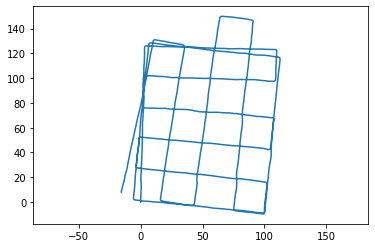

In [19]:
poses = np.array(poses)
st = 0; stp = -1
plt.figure()
plt.plot(poses[st:stp,0], poses[st:stp,1], )
plt.axis('equal')

In [20]:
import pickle

with open("./submaps_node_poses.pkl", 'wb') as f:
    pickle.dump((finished_submaps, node_poses),f)


In [36]:
len(finished_submaps), len(node_poses)

(224, 9905)

<IPython.core.display.Javascript object>


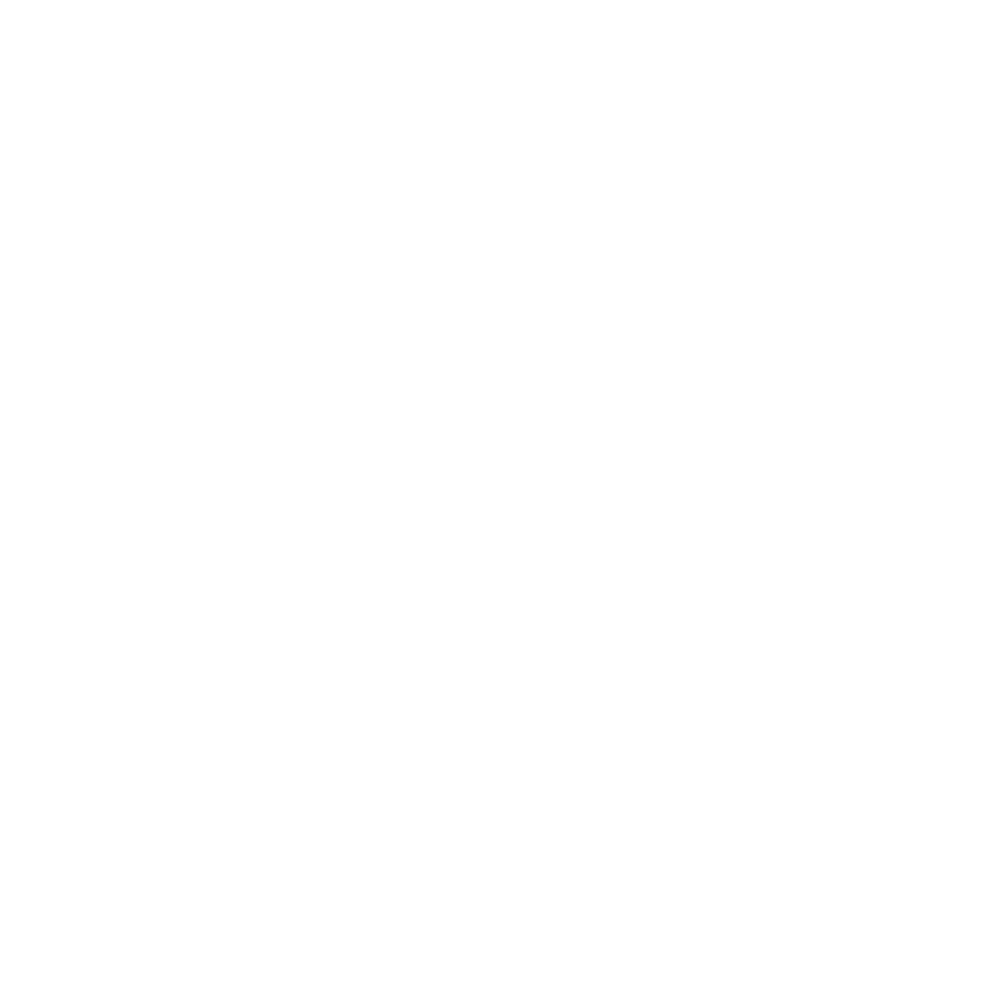

AttributeError: 'bytes' object has no attribute 'grid'

In [24]:
#%matplotlib inline
%matplotlib notebook
%matplotlib notebook
plt.figure(figsize = (10,10))
#plt.imshow(1-(finished_submaps[2].grid.grid.T> 0), cmap='gray') 
plt.imshow(1 - (finished_submaps[0].grid.grid.T>0), cmap='gray') 
#print(np.sum(finished_submaps[1].grid.grid >0))

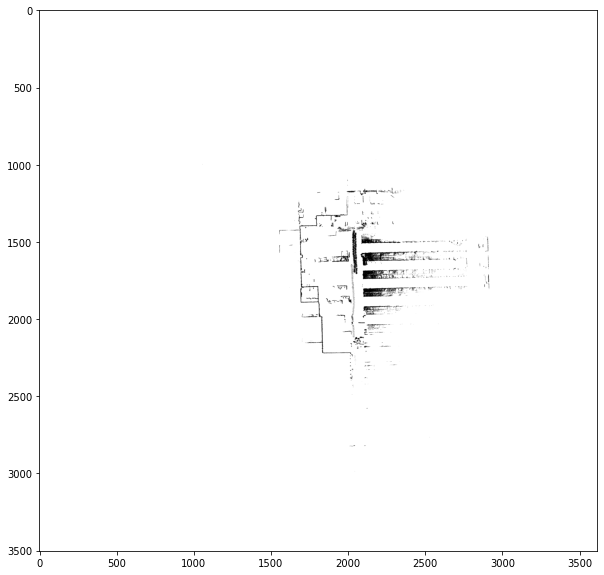

In [225]:
#%matplotlib notebook
#%matplotlib notebook
plt.figure(figsize = (10,10))
#plt.figure()
plt.imshow(1 - (active_submaps[1].grid.grid.T>0), cmap='gray') 

In [63]:
smap = finished_submaps[0]
gshape = smap.grid.grid.shape
hs = np.arange(1,5)
h_grid_res = 2**(hs) * grid_res

g0 = Grid2D(h_grid_res[0], grid_alpha)
#g0.set_grid(np.full(, 0, dtype=np.uint8))

AttributeError: 'bytes' object has no attribute 'grid'

In [115]:
ceil(gshape[0]/2)


NameError: name 'ceil' is not defined

In [238]:
#gshape/(2**hs[0])

#gshape


#@numba.njit(fastmath=True, parallel=True)
def compute_hierarchical_grid(grid2d, num_levels):
    hgrids=[]
    levels = np.arange(1, num_levels +1)
    grid_shape = grid2d.grid.shape
    prev_grid = grid2d
    for level in levels:
        grid_shape = prev_grid.grid.shape
        #win = 2**level
        shape = (int(np.ceil(grid_shape[0]/2)), int(np.ceil(grid_shape[1]/2)))
        hgrid_res = 2 * prev_grid.grid_res
        grid = Grid2D(grid_res = hgrid_res)
        grid.set_grid(np.full(shape, 0, dtype=np.uint8))
        grid.origin = (prev_grid.origin/2).astype(np.int32)
        #grid_arr = np.full(shape, 0, dtype=np.uint8)
        grid.set_grid(compute_half_res_grid(grid.grid, prev_grid.grid))
        hgrids.append(grid)
        prev_grid = grid
    return hgrids
                    
@numba.njit(fastmath=True, parallel=True)                    
def compute_half_res_grid(half_res_grid, full_res_grid):
    for i in range(half_res_grid.shape[0]):
        for j in range(half_res_grid.shape[1]):
            xrange = 2*i, min(2*i+2, full_res_grid.shape[0])
            yrange = 2*j, min(2*j+2, full_res_grid.shape[1])
            #half_res_grid[i,j] = np.max(full_res_grid[xrange[0]: xrange[1], yrange[0]: yrange[1]])
            #Below is faster
            half_res_grid[i,j] = max(full_res_grid[xrange[0]: xrange[1], yrange[0]: yrange[1]].flatten())
            #if i > 20:
            #    break
    return half_res_grid

def hierarchical_search(hgrids,pose_estimate, frame, x_search_window,
                        y_search_window, angle_search_window, max_range=60, score_th = 0.2, debug = False):
    best_pose = pose_estimate
    hscores = []
    hnum_visited = []
    for i in reversed(range(len(hgrids))):
        grid = hgrids[i]
        angular_res = grid.grid_res/max_range
        num_x = int(np.ceil((x_search_window[1] - x_search_window[0])/grid.grid_res))
        num_y = int(np.ceil((y_search_window[1] - y_search_window[0])/grid.grid_res))
        num_t = int(np.ceil(angle_search_window[1] - angle_search_window[0]/angular_res))
        
        search_space = utils.grid_space(best_pose, 
                                        x_search_window, y_search_window, angle_search_window, num_x, num_y, num_t)
        scores, num_visited = grid.search(frame, search_space, count_once=True)
        #hscores.append(scores)
        #hnum_visited.append(num_visited)
        best = np.argmax(scores)
        #best_normalized_score = scores[best]/len(frame)
        best_normalized_score = scores[best]/num_visited[best]
        #print(f"Score for {i}th grid is {best_normalized_score}")
        if best_normalized_score < score_th:
            if debug:
                print(f"Score below thresold {score_th} score :{best_normalized_score}")
            return None, best_normalized_score
        best_pose = search_space[best]
        if debug:
            print(f"For {i}th grid num_x:{num_x}, num_y:{num_y}, num_t:{num_t} , grid_res {grid.grid_res}, anguler res {angular_res}")
            print(f"angle_search_window {angle_search_window}")
            print(f"Score for {i}th grid is {best_normalized_score}")
            print(f"Best_pose for {i}th grid {best_pose}")
        #x_search_window = (best_pose[0] - grid.grid_res, best_pose[0])
        #y_search_window = (best_pose[1] - grid.grid_res, best_pose[1])
        x_search_window = (-grid.grid_res, grid.grid_res)
        y_search_window = (-grid.grid_res, grid.grid_res)
        angle_search_window = (-angular_res,angular_res)
    return best_pose,best_normalized_score #hscores, hnum_visited 
        
#%time gs = compute_hierarchical_grid(smap.grid, num_levels=8)

In [77]:
if finished_submaps[0].iscompressed:
    finished_submaps[0].decompress_data()
g = finished_submaps[0].grid.grid

#g = np.random.randn(1000,1000)
grid_shape = g.shape
        #win = 2**level
shape = (int(np.ceil(grid_shape[0]/2)), int(np.ceil(grid_shape[1]/2)))

gr = np.full(shape, 0, dtype=np.uint8)
%time compute_half_res_grid(gr, g)

/home/arindam/myvenv/venv375/lib/python3.7/site-packages/numba/core/typed_passes.py:314: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see https://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "<ipython-input-76-26079f098d8b>", line 27:
@numba.njit(fastmath=True, parallel=True)                    
def compute_half_res_grid(half_res_grid, full_res_grid):
^

  state.func_ir.loc))


CPU times: user 1.71 s, sys: 1e+03 ns, total: 1.71 s
Wall time: 1.71 s


array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

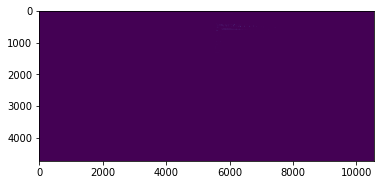

In [78]:
plt.imshow(g)

In [79]:
smap = finished_submaps[0]
if smap.iscompressed:
    smap.decompress_data()
%time gs = compute_hierarchical_grid(smap.grid, num_levels=4)
gs.insert(0, smap.grid)

CPU times: user 2.05 s, sys: 4 ms, total: 2.05 s
Wall time: 2.05 s


In [80]:
#gs = None
len(insertion_fr_ids), len(node_poses), len(poses), print(node_poses[0])

[0.         0.         1.57079633]


(14834, 14834, 33442, None)

In [81]:
i = 50
npose = node_poses[i]
spose_estimate = combine_yelli_poses(get_inverse_yelli_pose(smap.pose), npose)
spose_estimate

array([0.07233993, 3.89721051, 1.56161513])

In [96]:
i = 4000
#fr_id =frame_list[i]
fr_id = insertion_fr_ids[i]
print("Fr id", fr_id)
x_search_window = (-5,5)
y_search_window = (-5,5)
angle_search_window = (-np.pi/6, np.pi/6)
#pose_estimate = poses[500] + np.array([2,3, np.pi/12])
spose_estimate = np.array([0,0,np.pi/2])
#npose = node_poses[i]
#spose_estimate = combine_yelli_poses(get_inverse_yelli_pose(smap.pose), npose)
ts, frame = lpb.get_frame(fr_id)
frame = np.copy(frame[:, :6]).astype(np.float64)
frame = frame[(frame[:,4]>0) & (frame[:,4] < 60)]
frame = frame[(frame[:,2] > zmin) & (frame[:,2] < zmax)]
frame_z = voxel_filter(frame[:,:3], voxel_size=0.05)
#frame_z,_ = voxel_filter_fast(frame_z, trunc=False, voxel = 1)
print(len(frame_z))
%time hpose = hierarchical_search(gs[:], spose_estimate, frame_z,x_search_window,y_search_window,angle_search_window, max_range = 32, score_th = 0, debug=True)
print("hpose",hpose, "pose",poses[i], fr_id)

Fr id 14278
2476
For 4th grid num_x:32, num_y:32, num_t:53 , grid_res 0.32, anguler res 0.01
angle_search_window (-0.5235987755982988, 0.5235987755982988)
Score for 4th grid is 0.33751052686555283
Best_pose for 4th grid [-0.80645161  4.35483871  1.63121157]
For 3th grid num_x:4, num_y:4, num_t:3 , grid_res 0.16, anguler res 0.005
angle_search_window (-0.01, 0.01)
Score for 3th grid is 0.22638387025485665
Best_pose for 3th grid [-0.89360255  4.02898216  1.64121157]
For 2th grid num_x:4, num_y:4, num_t:3 , grid_res 0.08, anguler res 0.0025
angle_search_window (-0.005, 0.005)
Score for 2th grid is 0.16311446352531087
Best_pose for 2th grid [-1.04194892  3.85812153  1.64121157]
For 1th grid num_x:4, num_y:4, num_t:3 , grid_res 0.04, anguler res 0.00125
angle_search_window (-0.0025, 0.0025)
Score for 1th grid is 0.12172318777294368
Best_pose for 1th grid [-1.06292094  3.77644359  1.64121157]
For 0th grid num_x:4, num_y:4, num_t:3 , grid_res 0.02, anguler res 0.000625
angle_search_window (-0

In [89]:
max_range = 20
angular_res = smap.grid_res/max_range
num_x = int(np.ceil((x_search_window[1] - x_search_window[0])/smap.grid_res))
num_y = int(np.ceil((y_search_window[1] - y_search_window[0])/smap.grid_res))
num_t = int(np.ceil(angle_search_window[1] - angle_search_window[0]/angular_res))
search_space = utils.grid_space(pose_estimate, x_search_window, y_search_window, angle_search_window, num_x, num_y, num_t)
    #scores = multimap.search(filtered_frame_z, search_space)
    #print()
%time scores = smap.search(frame_z, search_space, count_once = False)
    #print(scores)
    
best = np.argmax(scores)
#pose = [search_space[b] for b in best]
#best_scores.append([scores[i][b] for i, b in enumerate(best)])
#best_scores.append(scores[best])
#pose = select_best_pose(pose, best_scores[-1])

spose = search_space[best]
spose

KeyboardInterrupt: 

KeyboardInterrupt: 

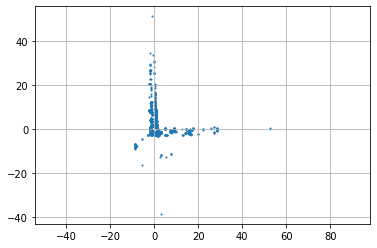

In [90]:
plt.scatter(frame_z[:,0], frame_z[:,1], s=1)
plt.axis('equal')
plt.grid()

In [91]:
np.sum((frame_z[:,0] < 0) & (frame_z[:,1] > 0))

388

In [1]:
poses[i], frame_list[i]
tframe_z = utils.transform_local_to_world(hpose, frame_z[:,:2])
fig = plt.figure(figsize=(10,10))
plot_map_new(smap.grid, alpha=2.0)
#plt.imshow(1-(smap.grid.grid>1), cmap='gray')
plt.scatter(frame_z[:,0], frame_z[:,1], s=1)
plt.scatter(tframe_z[:,0], tframe_z[:,1], s=1)

plt.xlim(-30,30)
plt.ylim(-30,30)
plt.show()
#plt.close()

NameError: name 'poses' is not defined

In [74]:
len(frame_z)

84

In [75]:
%matplotlib inline

In [27]:
fr_id =frame_list[1100]
hposes =[]
def dis(i):
    fr_id =frame_list[i]
    x_search_window = (-10,10)
    y_search_window = (-10,10)
    angle_search_window = (-np.pi/3, np.pi/3)
    pose_estimate = poses[i] + np.array([5,5, np.pi/12])
    #pose_estimate = np.array([0,0,np.pi/2])
    ts, frame = lpb.get_frame(fr_id)
    frame = np.copy(frame[:, :6]).astype(np.float64)
    frame = frame[(frame[:,4]>0) & (frame[:,4] < 60)]
    frame = frame[(frame[:,2] > zmin) & (frame[:,2] < zmax)]
    frame_z = voxel_filter(frame[:,:3], voxel_size=0.05)
    #frame_z,_ = voxel_filter_fast(voxel_filter(frame, voxel_size=0.05), trunc=False, voxel = 0.5)
    hpose = hierarchical_search(gs[:-1], pose_estimate, frame_z,x_search_window,y_search_window,angle_search_window, max_range = 32, score_th = 1)
    #if hpose is None:
    #    break
    if hpose is not None:
        hposes.append(hpose)
    #if fr_id % 100 == 0:
    #    print(f"Done {fr_id} frames")
    harr = np.array(hposes) 
    plt.figure()
    plt.plot(poses[:i,0], poses[:i, 1], 'o-')
    plt.plot(harr[:i,0], harr[:i,1], 'o-')
    plt.title(f"{i}")
#hposes = np.array(hposes)
#%time hierarchical_search(gs, poses[500], frame_z,x_search_window,y_search_window,angle_search_window, max_range = 32, score_th = 0.2)

interact(dis,i = IntSlider(min = 10, max = len(poses)))

interactive(children=(IntSlider(value=10, description='i', max=33442, min=10), Output()), _dom_classes=('widge…

<function __main__.dis(i)>

In [38]:
%matplotlib inline
submap_poses = np.array([submap.pose for submap in finished_submaps])

def dis(i):
    plt.figure(figsize=(7,7))
    plt.plot(submap_poses[:,0], submap_poses[:,1], 'o')
    plt.plot(submap_poses[i,0], submap_poses[i,1], 'o')
    plt.axis('equal')
interact(dis, i = IntSlider(min = 0, max = len(submap_poses)))

interactive(children=(IntSlider(value=0, description='i', max=224), Output()), _dom_classes=('widget-interact'…

<function __main__.dis(i)>

In [22]:
class Constraint:
    def __init__(self, node_ids, relative_pose):
        self.node_ids = node_ids
        self.relative_pose = relative_pose

10146 10146


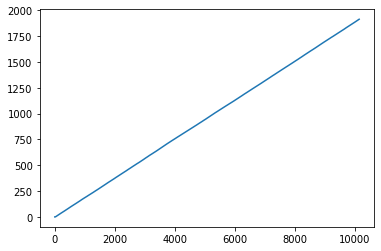

In [23]:
len(node_poses), zmin, zmax

node_dists = np.cumsum(np.linalg.norm(node_poses[1:,:2]-node_poses[:-1,:2], axis = 1))
node_dists = np.concatenate(([0],node_dists))
print(len(node_dists), len(node_poses))
plt.figure()
plt.plot(node_dists)

In [82]:
#one shot
dist_th = 10
x_search_window = (-5,5)
y_search_window = (-5,5)
angle_search_window = (-np.pi/6, np.pi/6)
score_th = 0.6

constraints=[]
for sid in range(len(finished_submaps)):
#for sid in range(2):
    submap = finished_submaps[sid]
    if submap.iscompressed:
        submap.decompress_data()
    hgrids =  compute_hierarchical_grid(submap.grid, num_levels=4)
    
    for nid in range(0,len(node_poses),5):
        npose = node_poses[nid]
        dist = np.linalg.norm(npose[:2] - submap.pose[:2])
        node_dist = abs(node_dists[nid] - node_dists[submap.node_ids[0]])
        if node_dist < 20:
            continue
        if nid not in submap.node_ids and (dist < 10):
            fr_id = insertion_fr_ids[nid]
            ts, frame = lpb.get_frame(fr_id)
            frame = np.copy(frame[:, :6]).astype(np.float64)
            frame = frame[(frame[:,4]>0) & (frame[:,4] < 60)]
            frame = frame[(frame[:,2] > zmin) & (frame[:,2] < zmax)]
            frame_z = voxel_filter(frame[:,:3], voxel_size=0.05)
            if len(frame_z) < 500:
                continue
            #Check all quadrants have points
            if (np.sum((frame_z[:,0] < 0) & (frame_z[:,1] > 0)) <10) or \
            (np.sum((frame_z[:,0] < 0) & (frame_z[:,1] < 0)) <10) or \
            (np.sum((frame_z[:,0] > 0) & (frame_z[:,1] > 0)) <10) or \
            (np.sum((frame_z[:,0] > 0) & (frame_z[:,1] < 0)) <10):
                continue
            frame_z,_ = voxel_filter_fast(frame_z, trunc=False, voxel = 0.25)  
            
            spose_estimate = combine_yelli_poses(get_inverse_yelli_pose(submap.pose), npose)
            hpose = hierarchical_search(hgrids, spose_estimate, frame_z,
                                        x_search_window,y_search_window,angle_search_window
                                        , max_range = 60, score_th = score_th)

            if hpose is not None: 
                print("sid, nids, pose",[submap.node_ids[0], nid], hpose)
                constraints.append(Constraint([submap.node_ids[0], nid], hpose))
    print(f"Submap {sid} done..")
    submap.compress_data()

sid, nids, pose [0, 4745] [0.08083547 3.68128968 1.59927052]
Submap 0 done..
Submap 1 done..
sid, nids, pose [88, 4785] [0.44442721 3.82497108 1.46712647]
sid, nids, pose [88, 4800] [0.00493561 1.30198165 1.5052793 ]
sid, nids, pose [88, 4805] [0.08252947 2.17384387 1.52918846]
sid, nids, pose [88, 4810] [0.15320877 3.20898614 1.52578281]
sid, nids, pose [88, 4815] [0.21691428 4.13322706 1.49711336]
sid, nids, pose [88, 4820] [0.33484873 4.91473896 1.47670776]
sid, nids, pose [88, 4825] [0.47060014 5.82249049 1.45478527]
Submap 2 done..
sid, nids, pose [132, 4840] [0.08176744 0.1231071  1.55595762]
sid, nids, pose [132, 4845] [0.15384034 1.05799059 1.51792105]
sid, nids, pose [132, 4860] [0.1682782  3.61002274 1.61467829]
sid, nids, pose [132, 4865] [0.16138742 4.4218562  1.62179339]
sid, nids, pose [132, 4870] [0.18426153 5.31325415 1.54583381]
sid, nids, pose [132, 4875] [0.26712948 6.29669577 1.4992985 ]
Submap 3 done..
sid, nids, pose [176, 3400] [-0.09170287  5.19075247 -1.5482504

sid, nids, pose [440, 5180] [-0.46629423  5.63342473  1.6083703 ]
sid, nids, pose [440, 5185] [-0.41470266  6.6160641   1.57350366]
sid, nids, pose [440, 9705] [ 0.14071079 12.48962243 -1.50973949]
sid, nids, pose [440, 9710] [ 0.0900638   8.38862773 -1.51681945]
sid, nids, pose [440, 9715] [ 0.2127417  12.41233477 -1.54641877]
Submap 10 done..
sid, nids, pose [484, 1965] [ 0.42944321  8.06489542 -1.55888305]
sid, nids, pose [484, 1970] [ 0.42758791  7.11641733 -1.66307018]
sid, nids, pose [484, 1975] [ 0.24252286  6.05555759 -1.64753494]
sid, nids, pose [484, 1980] [ 0.18018169  5.15015444 -1.59316983]
sid, nids, pose [484, 1985] [ 0.45064975  8.49273834 -1.56397116]
sid, nids, pose [484, 1990] [ 0.35550455  6.53019259 -1.55463392]
sid, nids, pose [484, 1995] [ 0.36456559  5.95355478 -1.56403727]
sid, nids, pose [484, 2000] [ 0.26762584  4.08699075 -1.57957637]
sid, nids, pose [484, 2005] [-0.03870767  0.3254437  -1.59257252]
sid, nids, pose [484, 2010] [ 0.3911613   5.48054481 -1.619

sid, nids, pose [1100, 5815] [-0.17161008  0.19235011  1.56985266]
sid, nids, pose [1100, 5830] [0.03364829 3.06286648 1.50347868]
sid, nids, pose [1100, 5835] [0.18110729 3.94480257 1.47012556]
sid, nids, pose [1100, 5840] [0.28924884 4.7762042  1.51206514]
Submap 25 done..
sid, nids, pose [1144, 5865] [0.2851538  1.18228028 1.64189524]
sid, nids, pose [1144, 5885] [0.06871135 4.63139969 1.62356828]
sid, nids, pose [1144, 5890] [0.06524673 5.51989893 1.58761529]
Submap 26 done..
sid, nids, pose [1188, 5910] [-0.06238808  1.42037891  1.55870282]
sid, nids, pose [1188, 5915] [-0.03182397  2.50971502  1.56221992]
sid, nids, pose [1188, 5920] [0.02051009 3.3830421  1.54314626]
sid, nids, pose [1188, 5925] [0.11549071 4.27770248 1.49622089]
sid, nids, pose [1188, 5930] [0.23431501 5.18373879 1.50751021]
Submap 27 done..
Submap 28 done..
sid, nids, pose [1276, 5995] [-0.01392139  7.00641886  1.6423028 ]
sid, nids, pose [1276, 6005] [0.04123739 5.96600422 1.58944407]
Submap 29 done..
Submap 

sid, nids, pose [1980, 9720] [ 0.43700682 12.91824142  1.53878938]
sid, nids, pose [1980, 9725] [ 0.58822881 13.9265086   1.53236419]
Submap 45 done..
sid, nids, pose [2024, 425] [ 0.47602888  7.88260208 -1.6214226 ]
sid, nids, pose [2024, 430] [ 0.35445116  6.87861359 -1.61601   ]
sid, nids, pose [2024, 435] [ 0.24775361  5.93867001 -1.61856472]
sid, nids, pose [2024, 450] [ 0.0350324   3.06882795 -1.59193904]
sid, nids, pose [2024, 455] [-0.03698992  2.15100399 -1.55235992]
sid, nids, pose [2024, 460] [-0.03891962  1.29225812 -1.53011057]
sid, nids, pose [2024, 465] [-0.03722628  0.20351704 -1.54719175]
sid, nids, pose [2024, 5120] [ 0.81675665 10.80146899 -1.65683792]
sid, nids, pose [2024, 5125] [ 0.69291789  9.82349681 -1.62112469]
sid, nids, pose [2024, 5130] [ 0.63046704  8.7863116  -1.63285907]
sid, nids, pose [2024, 5135] [ 0.5216525   7.71748327 -1.6635844 ]
sid, nids, pose [2024, 5140] [ 0.327909    6.78285777 -1.69996121]
sid, nids, pose [2024, 5145] [ 0.17252775  5.8695253

sid, nids, pose [3344, 250] [-0.08131524  1.86693624 -1.56675946]
sid, nids, pose [3344, 4925] [ 0.34468804  8.45557641 -1.6023942 ]
sid, nids, pose [3344, 4930] [ 0.23647015  7.51438868 -1.63897611]
sid, nids, pose [3344, 4935] [ 0.15293551  6.57975884 -1.66679419]
sid, nids, pose [3344, 4940] [ 0.02424701  5.72632093 -1.64109819]
sid, nids, pose [3344, 4945] [-0.06624518  4.72821686 -1.61351095]
sid, nids, pose [3344, 4950] [-0.06369398  6.35941946 -1.54993538]
sid, nids, pose [3344, 4955] [-0.06706729  5.65243936 -1.56155698]
sid, nids, pose [3344, 9910] [0.15087569 0.82813047 1.56180568]
sid, nids, pose [3344, 9915] [0.22652093 1.83020004 1.56594671]
sid, nids, pose [3344, 9920] [0.34365952 5.50821298 1.59610409]
sid, nids, pose [3344, 9925] [0.27319261 3.75108666 1.59213317]
sid, nids, pose [3344, 9930] [0.33964182 4.78364987 1.5867734 ]
sid, nids, pose [3344, 9935] [0.24247778 2.91512349 1.55863351]
sid, nids, pose [3344, 9940] [0.32488352 3.7332375  1.54717475]
sid, nids, pose [

sid, nids, pose [4752, 60] [0.22986268 2.70968678 1.58385088]
sid, nids, pose [4752, 65] [0.30809183 3.73114518 1.56071559]
sid, nids, pose [4752, 70] [0.35484177 4.65800923 1.50827274]
sid, nids, pose [4752, 75] [0.43159482 5.51455121 1.49883778]
sid, nids, pose [4752, 80] [0.5761288  6.58489367 1.56464982]
sid, nids, pose [4752, 85] [0.64936124 9.17783224 1.68188776]
sid, nids, pose [4752, 90] [0.50349567 8.49910011 1.67621863]
sid, nids, pose [4752, 95] [0.4880426  9.51767688 1.66732067]
sid, nids, pose [4752, 100] [ 0.42870174 10.44741612  1.65193088]
Submap 108 done..
sid, nids, pose [4796, 90] [0.12822484 0.06155981 1.64583065]
sid, nids, pose [4796, 95] [0.12341163 1.03127016 1.63693269]
sid, nids, pose [4796, 100] [0.0614612  1.95811419 1.62019055]
sid, nids, pose [4796, 105] [0.08085838 2.91194209 1.60429192]
sid, nids, pose [4796, 110] [0.07986708 3.86863255 1.57148534]
sid, nids, pose [4796, 115] [0.17823724 4.82338874 1.48080789]
sid, nids, pose [4796, 120] [0.24546214 5.86

sid, nids, pose [5016, 9840] [ 0.01880434  9.51992301 -1.58022253]
sid, nids, pose [5016, 9845] [-0.04543351  7.21166997 -1.52295218]
Submap 114 done..
sid, nids, pose [5060, 345] [-0.05111975 -0.80516938  1.65029645]
sid, nids, pose [5060, 350] [-0.09772497  0.07508598  1.5544328 ]
sid, nids, pose [5060, 355] [0.00350822 1.07406071 1.44456382]
sid, nids, pose [5060, 360] [0.1571593  1.9013202  1.48640038]
sid, nids, pose [5060, 365] [0.26170901 2.78051349 1.50759308]
sid, nids, pose [5060, 370] [0.38551457 3.71597536 1.50433833]
sid, nids, pose [5060, 375] [0.46665767 4.76559927 1.49875097]
sid, nids, pose [5060, 380] [0.54145202 5.55134851 1.53609996]
sid, nids, pose [5060, 385] [0.61122388 6.40359756 1.57288113]
sid, nids, pose [5060, 390] [0.66123393 7.39695509 1.57411753]
sid, nids, pose [5060, 395] [0.6957506  8.40764292 1.55408586]
sid, nids, pose [5060, 400] [0.75741697 9.41190112 1.54851992]
sid, nids, pose [5060, 405] [ 0.86814653 10.46077424  1.50723224]
sid, nids, pose [506

sid, nids, pose [5236, 565] [0.57651003 7.3515633  1.53289905]
sid, nids, pose [5236, 570] [0.6437218  8.28553346 1.5796128 ]
sid, nids, pose [5236, 575] [0.65436312 9.19113603 1.5812183 ]
sid, nids, pose [5236, 580] [ 0.68651394 10.13096073  1.58558842]
sid, nids, pose [5236, 585] [ 0.73463107 11.15239585  1.56856144]
sid, nids, pose [5236, 590] [ 0.78659737 11.97604143  1.54876127]
sid, nids, pose [5236, 1935] [ 2.36604018  3.79761252 -3.11929444]
sid, nids, pose [5236, 1940] [ 1.5058239   3.75628121 -2.69978805]
sid, nids, pose [5236, 1945] [ 0.71538706  3.28718784 -2.25185379]
sid, nids, pose [5236, 1950] [ 0.26950133  2.55418672 -1.71863533]
sid, nids, pose [5236, 1955] [ 0.22145553  1.73805201 -1.50314668]
sid, nids, pose [5236, 1960] [ 0.20674469  0.84693232 -1.52109521]
sid, nids, pose [5236, 9605] [ 0.62596575  6.31834056 -1.59300092]
sid, nids, pose [5236, 9610] [ 0.52667374  5.4263133  -1.62177694]
sid, nids, pose [5236, 9615] [ 0.45846828  4.5138454  -1.58670284]
sid, nids,

sid, nids, pose [5544, 895] [ 1.2927298  11.93043024  1.4678507 ]
sid, nids, pose [5544, 900] [ 1.40832901 12.78149672  1.46526678]
Submap 126 done..
sid, nids, pose [5588, 880] [-0.13911378  0.74488104  1.61473583]
sid, nids, pose [5588, 890] [0.02934644 2.55055996 1.45889943]
sid, nids, pose [5588, 895] [0.16540078 3.5615715  1.49664409]
sid, nids, pose [5588, 900] [0.30246841 4.3586348  1.48472683]
sid, nids, pose [5588, 905] [0.3883949  5.35332466 1.48410842]
sid, nids, pose [5588, 910] [0.47305387 6.2132195  1.49210642]
sid, nids, pose [5588, 915] [0.57658086 7.2077875  1.49159494]
sid, nids, pose [5588, 920] [0.74742788 8.17204981 1.49424792]
sid, nids, pose [5588, 925] [0.85885571 9.10584044 1.50947831]
sid, nids, pose [5588, 930] [ 0.94138926 10.02524578  1.53284702]
sid, nids, pose [5588, 935] [ 1.05300257 10.91306715  1.5553175 ]
sid, nids, pose [5588, 940] [ 1.08685503 11.93739121  1.55044344]
sid, nids, pose [5588, 945] [ 1.17230398 12.95492764  1.53603917]
Submap 127 done.

sid, nids, pose [6336, 2745] [0.30963907 0.84387774 1.55058208]
sid, nids, pose [6336, 2750] [0.38666697 1.75445515 1.54261144]
sid, nids, pose [6336, 2755] [0.45089579 2.50023759 1.53761766]
sid, nids, pose [6336, 2760] [0.51004959 3.39535862 1.50911139]
sid, nids, pose [6336, 2765] [0.63285887 4.27636789 1.32222693]
sid, nids, pose [6336, 2770] [0.90585571 5.01211253 0.9836644 ]
sid, nids, pose [6336, 2775] [1.5456978  5.64439654 0.48147037]
sid, nids, pose [6336, 2780] [2.35024300e+00 5.94144001e+00 4.20120476e-04]
Submap 144 done..
Submap 145 done..
Submap 146 done..
sid, nids, pose [6468, 4020] [0.69134374 8.6142721  1.5299603 ]
sid, nids, pose [6468, 4025] [0.78803439 9.56350352 1.56542642]
Submap 147 done..
sid, nids, pose [6512, 4025] [-0.12449961  1.20652529  1.58464349]
sid, nids, pose [6512, 4030] [-0.00651009  2.20470625  1.45137364]
sid, nids, pose [6512, 4035] [0.14189348 3.12466004 1.48473838]
sid, nids, pose [6512, 4040] [0.26117633 4.12964447 1.49312641]
sid, nids, pos

sid, nids, pose [8492, 4440] [1.09080964 9.00156104 0.04010657]
sid, nids, pose [8492, 4445] [2.00840887 9.03008902 0.03116992]
sid, nids, pose [8492, 4455] [3.8378495  8.94080902 0.01921605]
sid, nids, pose [8492, 4460] [4.75780037 8.89718425 0.02651645]
sid, nids, pose [8492, 4465] [5.63537873 8.94650719 0.08324898]
Submap 193 done..
sid, nids, pose [8536, 4445] [1.22447207 1.70977827 0.68172088]
sid, nids, pose [8536, 4455] [2.67147237 2.81687134 0.6550623 ]
sid, nids, pose [8536, 4460] [3.42024777 3.32243936 0.66102937]
sid, nids, pose [8536, 4465] [4.20438164 3.86059063 0.71907621]
sid, nids, pose [8536, 4470] [4.92667066 4.44226538 0.73392497]
sid, nids, pose [8536, 4475] [5.58790063 5.01821723 0.72316113]
sid, nids, pose [8536, 4480] [6.25050599 5.55137857 0.69469967]
sid, nids, pose [8536, 4485] [6.8807363  6.1033061  0.67612762]
sid, nids, pose [8536, 4490] [7.60114462 6.56013259 0.70497978]
sid, nids, pose [8536, 4495] [8.25426815 7.11751425 0.69228841]
sid, nids, pose [8536,

sid, nids, pose [9768, 395] [ 0.69787253  9.30478462 -1.59189591]
sid, nids, pose [9768, 400] [ 0.63651856  8.3385555  -1.60281421]
sid, nids, pose [9768, 5075] [ 1.1419146  12.98243828 -1.65782343]
sid, nids, pose [9768, 5080] [ 0.70129337  5.06293612 -1.56474847]
sid, nids, pose [9768, 5085] [ 0.6516224   4.08514406 -1.56826764]
sid, nids, pose [9768, 5090] [ 0.95322633  9.71025703 -1.58441086]
sid, nids, pose [9768, 5095] [ 0.90725908  8.6455033  -1.61296527]
sid, nids, pose [9768, 5100] [ 0.93189628  9.88712186 -1.64741638]
sid, nids, pose [9768, 5105] [ 0.8141655   9.22169704 -1.67972551]
sid, nids, pose [9768, 5110] [ 0.65694455  7.71569748 -1.70757253]
Submap 222 done..
sid, nids, pose [9812, 340] [ 0.45082503  8.1526091  -1.47279433]
sid, nids, pose [9812, 345] [ 0.51538053  7.60355212 -1.48950008]
sid, nids, pose [9812, 350] [ 0.53325104  6.46889694 -1.58136374]
sid, nids, pose [9812, 355] [ 0.55961642  8.38643433 -1.69656605]
sid, nids, pose [9812, 360] [ 0.28188836  4.759707

In [83]:
import pickle
with open("./cons.pickle",'wb') as f:
    pickle.dump(constraints,f)
#pickle.dump(constraints,"./cons.pickle")

In [116]:
with open("./cons.pickle", 'rb') as f:
    constraints = pickle.load(f)

In [117]:
%matplotlib inline
def dif(i):
    plt.figure(figsize = (10,10))
    plt.plot(node_poses[:,0], node_poses[:,1], label='unoptimized poses')
    #plt.plot(oposes[:,0], oposes[:,1], label = 'optimized poses')
    plt.axis('equal')
    
    plt.legend()
    plt.grid()

    for constraint in constraints:
        np = node_poses[constraint.node_ids[0]]
        cp =combine_yelli_poses(np, constraint.relative_pose)
        
        plt.plot([np[0], cp[0]], [np[1], cp[1]],'o-', 'g' )
        plt.plot(cp[0], cp[1], 'o', c='r', label = 'constraints')
        
    constraint = constraints[i]
    cp =combine_yelli_poses(node_poses[constraint.node_ids[0]], constraint.relative_pose)
    plt.plot(cp[0], cp[1], 'o', c='g', label = 'constraints')
    
    plt.title(f"Dataset:{dataset}\n{i} {constraint.node_ids} ")
    plt.show()
    
interact(dif, i = IntSlider(min = 0, max = len(constraints)))

interactive(children=(IntSlider(value=0, description='i', max=1387), Output()), _dom_classes=('widget-interact…

<function __main__.dif(i)>

In [118]:
g2o_nps = node_poses.copy()
for i in range(len(node_poses)):
    g2o_nps[i,2] = normalize_pose(node_poses[i,2]- np.pi/2)

g2o_cons = constraints
for i in range(len(constraints)):
    g2o_cons[i].relative_pose[2] = normalize_pose(constraints[i].relative_pose[2] - np.pi/2)

    

In [119]:
import g2o

class PoseGraphOptimization(g2o.SparseOptimizer):
    def __init__(self):
        super().__init__()
        solver = g2o.BlockSolverSE2(g2o.LinearSolverCholmodSE2())
        solver = g2o.OptimizationAlgorithmLevenberg(solver)
        super().set_algorithm(solver)

    def optimize(self, max_iterations=20):
        super().initialize_optimization()
        super().optimize(max_iterations)

    def add_vertex(self, id, pose, fixed=False):
        v_se2 = g2o.VertexSE2()
        v_se2.set_id(id)
        #v_se2.set_estimate(pose)
        v_se2.set_estimate_data(pose)
        v_se2.set_fixed(fixed)
        super().add_vertex(v_se2)

    def add_edge(self, vertices, measurement, 
            information=np.identity(3),
            robust_kernel=None):

        edge = g2o.EdgeSE2()
        for i, v in enumerate(vertices):
            if isinstance(v, int):
                v = self.vertex(v)
            edge.set_vertex(i, v)

        #edge.set_measurement(measurement)  # relative pose
        edge.set_measurement(g2o.SE2(measurement))
        edge.set_information(information)
        if robust_kernel is not None:
            edge.set_robust_kernel(robust_kernel)
        super().add_edge(edge)
        
    def add_edge_from_state(self, vertices, 
            information=np.identity(3),
            robust_kernel=None):

        edge = g2o.EdgeSE2()
        for i, v in enumerate(vertices):
            if isinstance(v, int):
                v = self.vertex(v)
            edge.set_vertex(i, v)

        edge.set_measurement_from_state()  # relative pose
        edge.set_information(information)
        if robust_kernel is not None:
            edge.set_robust_kernel(robust_kernel)
        super().add_edge(edge)    
    

    def get_pose(self, id):
        return self.vertex(id).estimate()
    
    


In [120]:
last_nid = finished_submaps[-1].node_ids[-1]
print(last_nid, len(node_poses))

10120 10146


In [123]:
ps = PoseGraphOptimization()
use_s = True
cdist_th = 1
#for i in range(len(g2o_nps)):
for i in range(last_nid+1):
    if i == 0:
        ps.add_vertex(i, g2o_nps[i], fixed = True)
    else:
        ps.add_vertex(i, g2o_nps[i])
if not use_s:
    #for i in range(len(g2o_nps)-1):
    for i in range(last_nid):
        ps.add_edge_from_state([i,i+1], information= np.identity(3))
else:
    for si in range(len(finished_submaps)):
        s = finished_submaps[si]
        snid = s.node_ids[0]
        for ni in s.node_ids[1:]:
            ps.add_edge_from_state([snid, ni], information = np.identity(3))
for i in range(len(g2o_cons)):
    #print(i, g2o_cons[i].relative_pose)
    constraint = g2o_cons[i]
    if np.linalg.norm(constraint.relative_pose[:2]) < cdist_th:
        ps.add_edge(constraint.node_ids, constraint.relative_pose, information= 1 * np.identity(3))
    
ps.optimize()
oposes=[]
#for i in range(len(g2o_nps)):
for i in range(last_nid+1):
    oposes.append(ps.get_pose(i).vector())
oposes = np.array(oposes)

(-15.242719957352428,
 116.71948038407811,
 -13.135470540105754,
 159.068200187748)

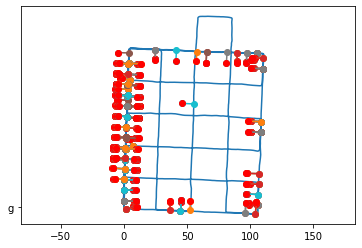

In [261]:
import numpy as np
plt.figure()
plt.plot(oposes[:,0], oposes[:,1], label = 'optimized poses')
for constraint in constraints:
        nps = oposes[constraint.node_ids[0]]
        cps =combine_yelli_poses(nps, constraint.relative_pose)
        
        plt.plot([nps[0], cps[0]], [nps[1], cps[1]],'o-', 'g' )
        plt.plot(cps[0], cps[1], 'o', c='r', label = 'constraints')
        
plt.axis('equal')

In [125]:
%matplotlib notebook
%matplotlib notebook
plt.figure()
plt.plot(node_poses[:,0], node_poses[:,1], label='unoptimized poses')
plt.plot(oposes[:,0], oposes[:,1], label = 'optimized poses')
plt.axis('equal')
plt.title(f"Dataset:{dataset}")
plt.legend()
plt.grid()

for constraint in constraints:
    cp =combine_yelli_poses(node_poses[constraint.node_ids[0]], constraint.relative_pose)
    plt.plot(cp[0], cp[1], 'o', c='r', label = 'constraints')

plt.show()

<IPython.core.display.Javascript object>

In [126]:
len(oposes), len(node_poses), zmin, zmax

(10121, 10146, 0.3, 2.0)

In [127]:
gzmin = 0.75 
gzmax = 1.2
ogrid = Grid2D(grid_alpha =1, grid_res = 0.05)
#for nid in range(len(node_poses)):
for nid in range(last_nid +1):
    #pose = node_poses[nid]
    pose = oposes[nid] + np.array([0,0,np.pi/2])
    fr_id = insertion_fr_ids[nid]
    ts, frame = lpb.get_frame(fr_id)
    frame = np.copy(frame[:, :6]).astype(np.float64)
    frame = frame[(frame[:,4]>0) & (frame[:,4] < 60)]
    frame = frame[frame[:,4]>1]
    frame = frame[(frame[:,2] > gzmin) & (frame[:,2] < gzmax)]
    frame_z = voxel_filter(frame[:,:3], voxel_size=0.05)
    ogrid.insert_points(pose, frame_z)

<IPython.core.display.Javascript object>


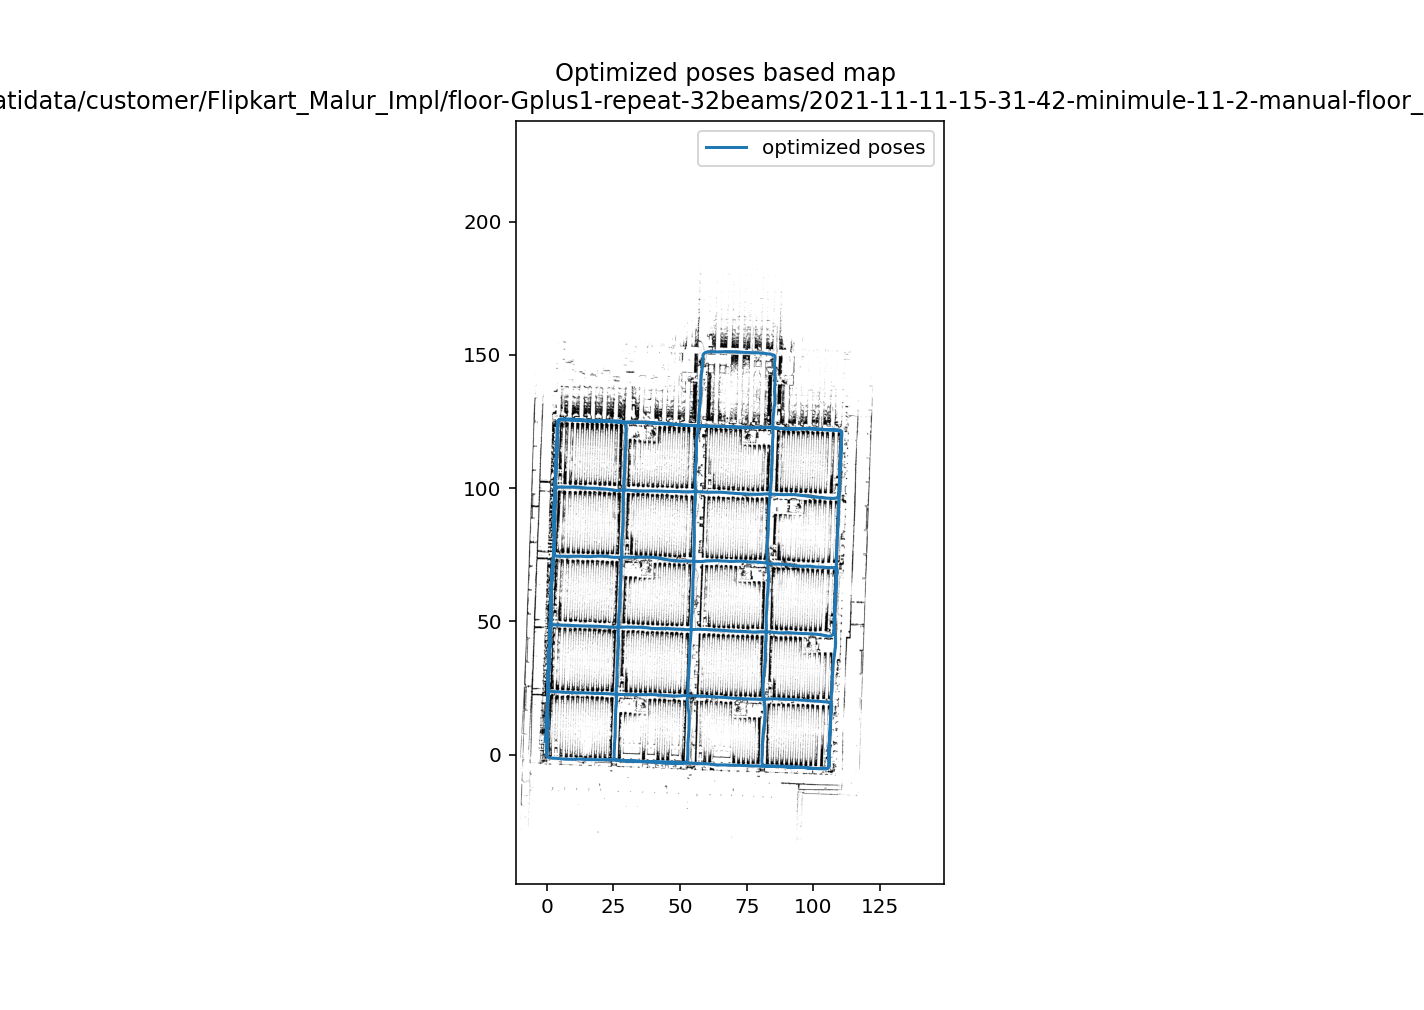

Text(0.5, 1.0, 'Optimized poses based map \nDataset:/atidata/customer/Flipkart_Malur_Impl/floor-Gplus1-repeat-32beams/2021-11-11-15-31-42-minimule-11-2-manual-floor_1__mapping/')

In [128]:
map_name = "/home/arindam/data/map_exptls/"
plt.figure()
plot_map_new(ogrid, alpha=2.0)
#plt.plot(node_poses[:,0], node_poses[:,1], label = 'unoptimized poses')
plt.plot(oposes[:,0], oposes[:,1], label = 'optimized poses')
plt.legend()
plt.title(f"Optimized poses based map \nDataset:{dataset}")
#plt.savefig(f"{map_name}/yelli_map.png", dpi=1000, bbox_inches="tight")

In [29]:
finished_submaps[2].node_ids

[88,
 89,
 90,
 91,
 92,
 93,
 94,
 95,
 96,
 97,
 98,
 99,
 100,
 101,
 102,
 103,
 104,
 105,
 106,
 107,
 108,
 109,
 110,
 111,
 112,
 113,
 114,
 115,
 116,
 117,
 118,
 119,
 120,
 121,
 122,
 123,
 124,
 125,
 126,
 127,
 128,
 129,
 130,
 131,
 132,
 133,
 134,
 135,
 136,
 137,
 138,
 139,
 140,
 141,
 142,
 143,
 144,
 145,
 146,
 147,
 148,
 149,
 150,
 151,
 152,
 153,
 154,
 155,
 156,
 157,
 158,
 159,
 160,
 161,
 162,
 163,
 164,
 165,
 166,
 167,
 168,
 169,
 170,
 171,
 172,
 173,
 174,
 175,
 176]

<IPython.core.display.Javascript object>


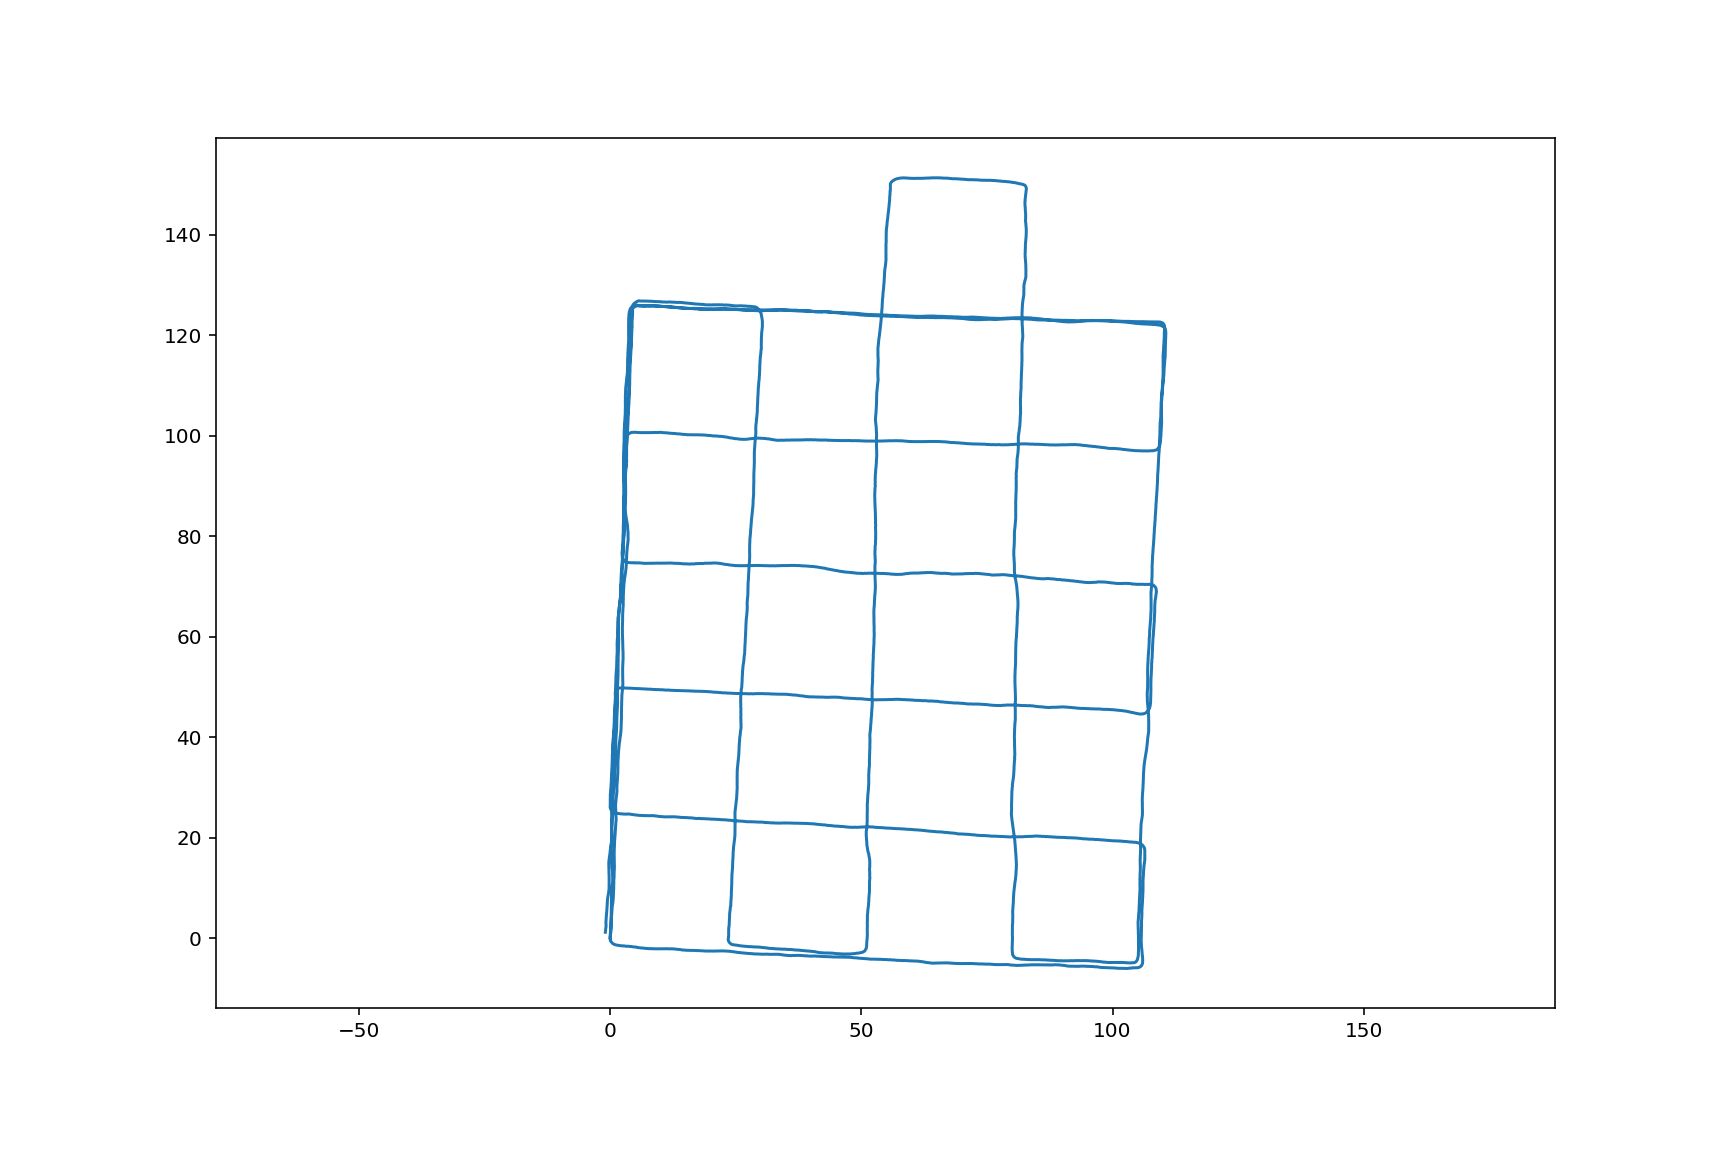

(-6.5233301377234545, 116.19091767046615, -13.8715680320457, 159.2551344576912)

In [105]:
temp_poses = node_poses.copy()
cdist_th = 1
for ci in range(len(g2o_cons)):
    
    cons = g2o_cons[ci]
    if np.linalg.norm(cons.relative_pose) > 1:
        continue
    
    sid, nid = cons.node_ids
    upto_id = sid if sid > nid else nid
    ps = PoseGraphOptimization()
    for ni in range(upto_id+1):
        pgpose = temp_poses[ni].copy()
        pgpose[2] = normalize_pose(pgpose[2]- np.pi/2)
        if ni == 0:                        
            ps.add_vertex(ni, pgpose, fixed = True)
        else:
            ps.add_vertex(ni, pgpose)
    for ni in range(0,upto_id):
        ps.add_edge_from_state([ni,ni+1], information=np.identity(3))
    
    ps.add_edge(cons.node_ids, cons.relative_pose, information= 1 * np.identity(3))
    ps.optimize()
    apose = temp_poses[upto_id].copy()
    for ni in range(upto_id +1):
        opose = ps.get_pose(ni).vector()
        opose[2] = normalize_pose(opose[2] + np.pi/2) 
        temp_poses[ni] = opose.copy()
    apose = combine_yelli_poses(temp_poses[upto_id],get_inverse_yelli_pose(apose) )
    for ni in range(upto_id +1, len(temp_poses)):
        temp_poses[ni] = combine_yelli_poses(apose, temp_poses[ni])
    
plt.figure()
plt.plot(temp_poses[:,0], temp_poses[:,1])
plt.axis('equal')

In [ ]:
%matplotlib notebook
%matplotlib notebook
plt.figure()
plt.plot(temp_poses[:,0], temp_poses[:,1])
plt.axis('equal')

In [326]:
temp_poses = node_poses.copy()
dist_th = 10
x_search_window = (-5,5)
y_search_window = (-5,5)
angle_search_window = (-np.pi/6, np.pi/6)
score_th = 0.7
cdist_th = 1.5
constraints = []
use_s = True
cscores = []
prev_node_dist = 0
for sid in range(42,len(finished_submaps)):
    submap = finished_submaps[sid]
    if submap.iscompressed:
        submap.decompress_data()
    hgrids = compute_hierarchical_grid(submap.grid, num_levels = 4)
    
    for nid in range(0, submap.node_ids[-1]):
        npose = temp_poses[nid]
        spose = temp_poses[submap.node_ids[0]]
        dist = np.linalg.norm(npose[:2] - spose[:2])
        node_dist = abs(node_dists[nid] - node_dists[submap.node_ids[0]])
        if node_dist < 20:
            continue
        if abs(node_dists[nid]-prev_node_dist) < 0.25:
            continue
        prev_node_dist = node_dists[nid]
        if nid not in submap.node_ids and (dist < dist_th):
            print(nid)
            fr_id = insertion_fr_ids[nid]
            ts, frame = lpb.get_frame(fr_id)
            frame = np.copy(frame[:, :6]).astype(np.float64)
            frame = frame[(frame[:,4]>0) & (frame[:,4] < 60)]
            frame = frame[(frame[:,2] > zmin) & (frame[:,2] < zmax)]
            frame_z = voxel_filter(frame[:,:3], voxel_size=0.05)
            if len(frame_z) < 500:
                continue
            #Check all quadrants have points
            if (np.sum((frame_z[:,0] < 0) & (frame_z[:,1] > 0)) <10) or \
            (np.sum((frame_z[:,0] < 0) & (frame_z[:,1] < 0)) <10) or \
            (np.sum((frame_z[:,0] > 0) & (frame_z[:,1] > 0)) <10) or \
            (np.sum((frame_z[:,0] > 0) & (frame_z[:,1] < 0)) <10):
                continue
            frame_z,_ = voxel_filter_fast(frame_z, trunc=False, voxel = 0.25)  
            
            spose_estimate = combine_yelli_poses(get_inverse_yelli_pose(spose), npose)
            hpose, cscore = hierarchical_search(hgrids, spose_estimate, frame_z,
                                        x_search_window,y_search_window,angle_search_window
                                        , max_range = 60, score_th = score_th)

            if hpose is not None: 
                thpose = combine_yelli_poses(spose, hpose)
                mid_pose = temp_poses[submap.node_ids[45]]
                dthpose = thpose[:2] - mid_pose[:2]
                #print(dthpose, spose, mid_pose)
                if np.linalg.norm(dthpose[:2]) > cdist_th:
                    print("Crossed cdist_th .Skipping...",np.linalg.norm(dthpose[:2]))
                    continue
                print("sid, nids, pose, cscore",[submap.node_ids[0], nid], hpose, cscore)
                print("Doing pose graph optimization")
                ps = PoseGraphOptimization()
                for i in range(0,submap.node_ids[-1] + 1 ):
                #for i in range(0,len(temp_poses)):
                    pgpose = temp_poses[i].copy()
    
                    pgpose[2] = normalize_pose(pgpose[2]- np.pi/2)
                    if i == 0:                        
                        ps.add_vertex(i, pgpose, fixed = True)
                    else:
                        ps.add_vertex(i, pgpose)
                    
                #for i in range(0,submap.node_ids[-1] + 1):
                #for i in range(0,nid+1):
                #for i in range(0,len(temp_poses)- 1):
                #    ps.add_edge_from_state([i,i+1], information=np.identity(3))
                for si in range(0, sid+1):
                    si_nid = finished_submaps[si].node_ids[0]
                    for ni in finished_submaps[si].node_ids[1:]:
                        ps.add_edge_from_state([si_nid, ni], information= np.identity(3))
                
                con_pose = hpose.copy()
                con_pose[2] = normalize_pose(con_pose[2] - np.pi/2)
                ps.add_edge([submap.node_ids[0], nid], con_pose, information= np.identity(3))
                ps.optimize()
                
                tpose = temp_poses[submap.node_ids[-1]].copy()
                for ti in range(0, submap.node_ids[-1] + 1):
                #for ti in range(0, len(temp_poses[i])):
                    temp_poses[ti] = ps.get_pose(ti).vector()
                    temp_poses[ti,2] = normalize_pose(temp_poses[ti,2] + np.pi/2)
                
                apose = combine_yelli_poses(temp_poses[submap.node_ids[-1]], get_inverse_yelli_pose(tpose) )
                for ti in range(submap.node_ids[-1]+1, len(temp_poses)):
                    temp_poses[ti] = combine_yelli_poses(apose, temp_poses[ti])
                
                constraints.append(Constraint([submap.node_ids[0], nid], hpose))
                cscores.append(cscore)
  
    print(f"Submap {sid} done..")
    submap.compress_data()

Submap 42 done..
Submap 43 done..
504
sid, nids, pose, cscore [1936, 504] [-7.9707857   2.85926949 -0.04349959] 0.7599895337405178
Doing pose graph optimization
506
sid, nids, pose, cscore [1936, 506] [-7.58782386  2.82309191 -0.04369992] 0.7631426643011833
Doing pose graph optimization
508
sid, nids, pose, cscore [1936, 508] [-7.16400031  2.76583885 -0.0421934 ] 0.7625440112536777
Doing pose graph optimization
510
sid, nids, pose, cscore [1936, 510] [-6.85326111  2.713329   -0.04937833] 0.7463405915483268
Doing pose graph optimization
512
sid, nids, pose, cscore [1936, 512] [-6.43996659  2.70793006 -0.05672744] 0.7609040623462698
Doing pose graph optimization
514
sid, nids, pose, cscore [1936, 514] [-5.97582054  2.6401791  -0.05170386] 0.7346996531486274
Doing pose graph optimization
516
518
Crossed cdist_th .Skipping... 1.5446162092608793
520
Crossed cdist_th .Skipping... 1.9075442931135245
521
Crossed cdist_th .Skipping... 2.1673759986103507
523
Crossed cdist_th .Skipping... 2.62779

211
213
215
217
219
221
223
225
227
229
231
233
235
237
239
241
243
245
247
249
251
253
255
257
259
261
263
265
267
269
Submap 77 done..
121
123
125
127
129
131
133
135
137
139
141
143
145
147
149
151
153
155
157
159
161
163
165
167
169
171
173
175
177
179
181
183
185
187
189
191
193
195
197
199
201
203
205
207
209
211
213
215
217
219
221
223
Submap 78 done..
95
97
99
101
103
105
107
109
111
113
115
117
119
121
123
125
127
129
131
133
135
137
139
141
143
145
147
149
151
153
155
157
159
161
163
165
167
169
171
173
175
177
179
181
183
185
187
189
191
Submap 79 done..
Submap 80 done..
Submap 81 done..
Submap 82 done..
Submap 83 done..
Submap 84 done..
Submap 85 done..
Submap 86 done..
Submap 87 done..
Submap 88 done..
Submap 89 done..
Submap 90 done..
Submap 91 done..
Submap 92 done..
Submap 93 done..
Submap 94 done..
Submap 95 done..
Submap 96 done..
Submap 97 done..
Submap 98 done..
Submap 99 done..
Submap 100 done..
Submap 101 done..
Submap 102 done..
Submap 103 done..
Submap 104 done.

Crossed cdist_th .Skipping... 4.888603675074408
195
Crossed cdist_th .Skipping... 4.474846648069613
197
Crossed cdist_th .Skipping... 4.208677401123687
199
Crossed cdist_th .Skipping... 3.8294463187024426
201
Crossed cdist_th .Skipping... 3.4330274819598268
203
Crossed cdist_th .Skipping... 3.0364742175706074
205
Crossed cdist_th .Skipping... 2.5945663138637793
207
Crossed cdist_th .Skipping... 2.272113379414877
209
Crossed cdist_th .Skipping... 1.849734364444586
211
sid, nids, pose, cscore [4884, 211] [0.86040787 7.21188643 1.527277  ] 0.7702585679145546
Doing pose graph optimization
213
sid, nids, pose, cscore [4884, 213] [0.86478687 7.50668675 1.52463096] 0.7669629182483387
Doing pose graph optimization
215
sid, nids, pose, cscore [4884, 215] [0.90818197 7.9120997  1.52583378] 0.7743705674289453
Doing pose graph optimization
217
sid, nids, pose, cscore [4884, 217] [0.9368802  8.28609484 1.52366165] 0.7573282211460165
Doing pose graph optimization
219
sid, nids, pose, cscore [4884, 2

275
277
279
281
283
285
287
289
291
293
295
297
299
301
303
305
307
309
311
313
315
317
Crossed cdist_th .Skipping... 6.414779530251057
319
321
323
325
327
329
331
Crossed cdist_th .Skipping... 3.872618484022274
332
Crossed cdist_th .Skipping... 3.60704223572246
334
Crossed cdist_th .Skipping... 3.2613177712826613
336
Crossed cdist_th .Skipping... 2.8077924337495253
338
Crossed cdist_th .Skipping... 2.427688165474435
340
Crossed cdist_th .Skipping... 1.9688681316986347
342
Crossed cdist_th .Skipping... 1.5664367675005342
344
sid, nids, pose, cscore [5016, 344] [-0.11394877  7.31588073  1.66577997] 0.7666552467777942
Doing pose graph optimization
346
sid, nids, pose, cscore [5016, 346] [-0.10814373  7.74651828  1.65874302] 0.7684676919749064
Doing pose graph optimization
348
350
sid, nids, pose, cscore [5016, 350] [-0.15441473  8.42120834  1.57112034] 0.7688644215534283
Doing pose graph optimization
352
sid, nids, pose, cscore [5016, 352] [-0.09488667  8.83303999  1.51673521] 0.74361726

2009
sid, nids, pose, cscore [5148, 2009] [-0.06025091  8.35317368 -1.57127046] 0.7648687828620138
Doing pose graph optimization
2011
sid, nids, pose, cscore [5148, 2011] [-0.10637257  7.95128464 -1.58108746] 0.7641384234841039
Doing pose graph optimization
2013
sid, nids, pose, cscore [5148, 2013] [-0.10230478  7.54867174 -1.58936619] 0.7665810311294226
Doing pose graph optimization
2015
sid, nids, pose, cscore [5148, 2015] [-0.14791113  7.15801443 -1.56369916] 0.7535062197780918
Doing pose graph optimization
2017
Crossed cdist_th .Skipping... 1.6306891746822039
2019
Crossed cdist_th .Skipping... 2.0059345768203745
2021
Crossed cdist_th .Skipping... 2.4097657137117396
2023
2024
Crossed cdist_th .Skipping... 3.1073212219536437
2026
Crossed cdist_th .Skipping... 3.5599143818106866
2028
Crossed cdist_th .Skipping... 3.895695407492858
2030
Crossed cdist_th .Skipping... 4.336132570136456
2032
Crossed cdist_th .Skipping... 4.716060746178371
2034
2036
Crossed cdist_th .Skipping... 5.47186746

623
sid, nids, pose, cscore [5280, 623] [0.33848891 9.43524442 1.60125101] 0.7385627590356573
Doing pose graph optimization
625
1901
1903
1905
1907
1909
1911
1913
1915
1917
1919
1921
1923
1925
1927
1929
1931
1933
1935
1937
1939
1941
1943
1945
1947
1949
1951
1953
1955
1957
1959
1961
1963
1965
1967
1969
1971
Submap 120 done..
565
567
569
571
573
575
577
579
581
583
585
587
589
591
593
595
597
599
601
603
605
607
609
611
613
615
617
619
621
623
625
627
Crossed cdist_th .Skipping... 6.916673004787208
629
631
Crossed cdist_th .Skipping... 6.014465874655039
633
Crossed cdist_th .Skipping... 5.69643880583441
635
Crossed cdist_th .Skipping... 5.314071165722961
637
Crossed cdist_th .Skipping... 4.994291104800262
639
641
Crossed cdist_th .Skipping... 4.1545754577170575
643
Crossed cdist_th .Skipping... 3.6954192460248634
645
Crossed cdist_th .Skipping... 3.25998124548123
647
Crossed cdist_th .Skipping... 2.992139788599079
649
Crossed cdist_th .Skipping... 2.673110309725298
651
Crossed cdist_th .

1275
sid, nids, pose, cscore [5940, 1275] [ 4.35965142  4.92310881 -0.03179383] 0.7231975146741112
Doing pose graph optimization
1277
sid, nids, pose, cscore [5940, 1277] [ 4.71317384  4.90035445 -0.0287109 ] 0.707355134532477
Doing pose graph optimization
1279
1281
1283
1285
1287
1289
1291
1293
1295
1297
Submap 135 done..
1205
1207
1209
1211
1213
1215
1217
1219
1221
1223
1225
1227
1229
1231
1233
1235
1237
1239
1241
1243
1245
1247
1249
1251
1253
1255
1257
1259
1261
1263
1265
1267
1269
1271
1273
1275
1277
1279
1281
1283
1285
1287
Crossed cdist_th .Skipping... 5.425487540969383
1289
1291
1293
1295
1297
1299
Crossed cdist_th .Skipping... 3.242161168386777
1301
1303
Crossed cdist_th .Skipping... 2.543052066411049
1305
1307
Crossed cdist_th .Skipping... 1.8447273777427946
1309
sid, nids, pose, cscore [5984, 1309] [0.24141185 6.93602143 1.57323606] 0.7403206952042048
Doing pose graph optimization
1311
1313
1315
1317
sid, nids, pose, cscore [5984, 1317] [0.36840423 8.52877321 1.54412378] 0.71

Crossed cdist_th .Skipping... 4.811491341347
2761
Crossed cdist_th .Skipping... 4.509642878740131
2763
2765
2767
2769
2771
2773
2775
2777
2779
2781
2783
2785
2787
2789
2791
2793
2795
2797
2799
2801
2803
2805
2807
2809
2811
2813
2815
Submap 144 done..
2731
2733
2735
2737
2739
2741
2743
2745
2747
2749
2751
2753
2755
2757
2759
2761
2763
2765
2767
2769
2771
2773
2775
2777
2779
2781
2783
2785
2787
2789
2791
2793
2795
2797
2799
2801
2803
2805
2807
2809
2811
2813
2815
2817
2819
Submap 145 done..
Submap 146 done..
3977
3979
3981
3983
3985
3987
3989
3991
3993
3995
3997
3999
4001
4003
4005
4007
4009
4011
4013
4015
4017
4019
4021
4023
sid, nids, pose, cscore [6468, 4023] [0.7824653  9.17927479 1.55898196] 0.724416939656902
Doing pose graph optimization
4025
sid, nids, pose, cscore [6468, 4025] [0.76402273 9.55317999 1.56605054] 0.7656111894127677
Doing pose graph optimization
4027
sid, nids, pose, cscore [6468, 4027] [0.80761247 9.96101835 1.48404721] 0.7542834883852582
Doing pose graph optimizat

2506
2508
2510
2512
2514
2516
2518
2520
2522
2524
2526
2528
2530
2532
2534
Submap 162 done..
2452
2454
2456
2458
2460
2462
2464
2466
2468
2470
2472
2474
2476
2478
2480
2482
2484
2486
2488
2490
2492
2494
2496
2498
2500
2502
2504
2506
2508
2510
2512
2514
2516
2518
2520
2522
2524
2526
2528
2530
2532
2534
2536
2538
2540
2542
2544
2546
2548
2550
2552
2554
2556
Submap 163 done..
2472
2474
2476
2478
2480
2482
2484
2486
2488
2490
2492
2494
2496
2498
2500
2502
2504
2506
2508
2510
2512
2514
2516
2518
2520
2522
2524
2526
2528
2530
2532
Submap 164 done..
Submap 165 done..
1465
1467
1469
1471
1473
1475
1477
1479
1481
1483
1485
1487
1489
1491
1493
1495
1497
1499
1501
1503
1505
1507
1509
1511
1513
1515
1517
1519
1521
1523
1525
1527
1529
1531
1533
1535
1537
1539
1541
1543
1545
1547
1549
1551
1553
1555
1557
1559
1561
1563
1565
Submap 166 done..
1469
1471
1473
1475
1477
1479
1481
1483
1485
1487
1489
1491
1493
1495
1497
1499
1501
1503
1505
1507
1509
1511
1513
1515
1517
1519
1521
1523
1525
1527
1529
1531


4563
4565
sid, nids, pose, cscore [8624, 4565] [0.41601035 7.7272689  1.54451576] 0.7196419695549028
Doing pose graph optimization
4567
4569
4571
4573
4575
4577
Submap 196 done..
4515
4517
4519
4521
4523
4525
4527
4529
4531
4533
4535
4537
4539
4541
4543
4545
4547
4549
4551
4553
4555
4557
4559
4561
4563
4565
4567
4569
4571
4573
4575
4577
4579
4581
4583
4585
4587
4588
4590
4592
4594
4596
4598
4600
4602
4604
4606
4608
4610
4612
4614
4616
4618
4620
Submap 197 done..
4541
4543
4545
4547
4549
4551
4553
4555
4557
4559
4561
4563
4565
4567
4569
4571
4573
4575
4577
4579
4581
4583
4585
4587
4588
4590
4592
4594
4596
4598
4600
4602
4604
4606
4608
4610
4612
4614
4616
4618
4620
4622
4624
4626
Submap 198 done..
Submap 199 done..
3541
3543
3545
3547
3549
3551
3553
3555
3557
3559
3561
3563
3565
3567
3569
3571
3573
3575
3577
3579
3581
3583
3585
3587
3589
3591
3593
3595
3597
3599
3601
3603
3605
3607
3609
3611
3613
3615
3617
3619
3621
3623
3625
3627
3629
3631
3633
3635
3637
Submap 200 done..
3555
3557
3559

Crossed cdist_th .Skipping... 4.336694121893615
5304
5306
5308
5310
5312
5314
5316
5318
5320
5322
5324
5326
5328
5330
5332
5334
5336
5338
5340
5342
5344
5346
5348
5350
5352
5354
5356
5358
5360
5362
5364
5366
5368
5370
5372
5374
5376
Submap 217 done..
523
sid, nids, pose, cscore [9592, 523] [ 0.4322545   9.45429428 -1.5480786 ] 0.7443123005096614
Doing pose graph optimization
525
sid, nids, pose, cscore [9592, 525] [ 0.40804314  9.0489947  -1.5568396 ] 0.7426405184506889
Doing pose graph optimization
527
sid, nids, pose, cscore [9592, 527] [ 0.43375322  8.69741657 -1.55994209] 0.7307424168338913
Doing pose graph optimization
529
sid, nids, pose, cscore [9592, 529] [ 0.39752973  8.294457   -1.56523009] 0.7458975357672946
Doing pose graph optimization
531
sid, nids, pose, cscore [9592, 531] [ 0.36944518  7.88252436 -1.56704581] 0.7257561672142057
Doing pose graph optimization
533
sid, nids, pose, cscore [9592, 533] [ 0.39148588  7.53699244 -1.5610094 ] 0.7108649943343063
Doing pose graph 

436
438
440
442
444
446
sid, nids, pose, cscore [9680, 446] [ 0.39813961  7.62421203 -1.61575476] 0.7100501639084591
Doing pose graph optimization
448
450
452
Crossed cdist_th .Skipping... 2.465345849105117
454
Crossed cdist_th .Skipping... 2.845698379474001
456
458
460
462
Crossed cdist_th .Skipping... 4.442230302678677
464
466
468
470
472
474
476
478
480
482
484
486
488
490
492
494
496
498
500
502
504
506
508
510
512
514
516
518
520
521
523
525
527
529
531
533
535
1955
1957
1959
1961
1963
1965
1967
1969
1971
1973
1975
1977
1979
1981
1983
1985
1987
1989
1991
1993
1995
1997
1999
2001
2003
2005
2007
2009
2011
2013
2015
2017
2019
2021
2023
2024
2026
2028
2030
2032
2034
2036
2038
2040
2042
2044
sid, nids, pose, cscore [9680, 2044] [0.53794797 7.66338513 1.53741683] 0.7569903920245199
Doing pose graph optimization
2046
sid, nids, pose, cscore [9680, 2046] [0.54133366 8.0110665  1.54010725] 0.7464115311581515
Doing pose graph optimization
2048
sid, nids, pose, cscore [9680, 2048] [0.6292257

313
sid, nids, pose, cscore [9812, 313] [ 0.26998541  7.71697849 -1.56717894] 0.7386271104935621
Doing pose graph optimization
315
sid, nids, pose, cscore [9812, 315] [ 0.27771812  7.42630629 -1.57617618] 0.7305594038295334
Doing pose graph optimization
317
sid, nids, pose, cscore [9812, 317] [ 0.2261248   6.96311451 -1.59169805] 0.7469915794487106
Doing pose graph optimization
319
Crossed cdist_th .Skipping... 1.7554827956598353
321
Crossed cdist_th .Skipping... 2.13335156261038
323
Crossed cdist_th .Skipping... 2.451316926994376
325
Crossed cdist_th .Skipping... 2.811529487102529
327
Crossed cdist_th .Skipping... 3.2168679917874137
329
Crossed cdist_th .Skipping... 3.5921818747751155
331
Crossed cdist_th .Skipping... 3.972276469771418
332
Crossed cdist_th .Skipping... 4.240072228166427
334
Crossed cdist_th .Skipping... 4.57778623854123
336
Crossed cdist_th .Skipping... 4.975928557417003
338
Crossed cdist_th .Skipping... 5.415278232418629
340
342
344
346
348
350
352
354
356
358
360
36

3383
sid, nids, pose, cscore [9900, 3383] [0.42980044 8.61944935 1.51572815] 0.7707410745428596
Doing pose graph optimization
3385
sid, nids, pose, cscore [9900, 3385] [0.49374563 9.02519854 1.53028992] 0.7803480826399092
Doing pose graph optimization
3387
sid, nids, pose, cscore [9900, 3387] [0.49840512 9.31994371 1.52779056] 0.7814559100243952
Doing pose graph optimization
3389
sid, nids, pose, cscore [9900, 3389] [0.5566305  9.67063988 1.52496508] 0.8037552609607241
Doing pose graph optimization
4925
sid, nids, pose, cscore [9900, 4925] [ 0.52448902  9.59904349 -1.62966027] 0.7622482527585654
Doing pose graph optimization
4927
sid, nids, pose, cscore [9900, 4927] [ 0.47285298  9.25012161 -1.63785782] 0.7765020309583951
Doing pose graph optimization
4929
4931
4933
sid, nids, pose, cscore [9900, 4933] [ 0.33262648  8.04940314 -1.67810211] 0.7894362375841436
Doing pose graph optimization
4935
sid, nids, pose, cscore [9900, 4935] [ 0.24759742  7.70507209 -1.68791564] 0.7325363108161719


173
175
177
179
181
183
185
3419
3421
3423
3425
3427
3429
3431
3433
3435
3437
3439
3441
3443
3445
3447
3449
3451
3453
3455
3457
3459
3461
3463
3465
3467
3469
3471
3473
3475
3477
3479
3481
3483
3485
3487
3489
3491
3493
3495
3497
3499
3501
3503
3505
3507
3509
3511
4790
4792
4794
4796
sid, nids, pose, cscore [10032, 4796] [ 0.93694756  8.51546137 -1.59876267] 0.7104643544080746
Doing pose graph optimization
4798
4800
sid, nids, pose, cscore [10032, 4800] [ 0.8565254   7.7559094  -1.58962967] 0.700180902667553
Doing pose graph optimization
4802
4804
4806
4808
4810
4812
4814
4816
4818
4820
4822
4824
4826
4828
4830
4832
4834
4836
4838
4840
4842
4844
4846
4848
4850
4852
4854
4856
4858
4860
4862
4864
4866
4868
4870
4872
4874
4876
4878
4880
4882
4884
4886
4888
4890
4892
4894
4896
Submap 228 done..


In [298]:
#temp_poses = node_poses.copy()
dist_th = 4
x_search_window = (-2,2)
y_search_window = (-2,2)
angle_search_window = (-np.pi/6, np.pi/6)
score_th = 0.6
cdist_th = 1.5
#constraints = []
use_s = True
#cscores = []
prev_node_dist = 0
for sid in range(0,len(finished_submaps)):
    submap = finished_submaps[sid]
    if submap.iscompressed:
        submap.decompress_data()
    hgrids = compute_hierarchical_grid(submap.grid, num_levels = 4)
    
    for nid in range(0, len(temp_poses)):#submap.node_ids[-1]):
        npose = temp_poses[nid]
        spose = temp_poses[submap.node_ids[0]]
        dist = np.linalg.norm(npose[:2] - spose[:2])
        node_dist = abs(node_dists[nid] - node_dists[submap.node_ids[0]])
        if node_dist < 20:
            continue
        if abs(node_dists[nid]-prev_node_dist) < 0.2:
            continue
        prev_node_dist = node_dists[nid]
        if nid not in submap.node_ids and (dist < dist_th):
            #print(nid)
            fr_id = insertion_fr_ids[nid]
            ts, frame = lpb.get_frame(fr_id)
            frame = np.copy(frame[:, :6]).astype(np.float64)
            frame = frame[(frame[:,4]>0) & (frame[:,4] < 60)]
            frame = frame[(frame[:,2] > zmin) & (frame[:,2] < zmax)]
            frame_z = voxel_filter(frame[:,:3], voxel_size=0.05)
            if len(frame_z) < 500:
                continue
            #Check all quadrants have points
            if (np.sum((frame_z[:,0] < 0) & (frame_z[:,1] > 0)) <10) or \
            (np.sum((frame_z[:,0] < 0) & (frame_z[:,1] < 0)) <10) or \
            (np.sum((frame_z[:,0] > 0) & (frame_z[:,1] > 0)) <10) or \
            (np.sum((frame_z[:,0] > 0) & (frame_z[:,1] < 0)) <10):
                continue
            frame_z,_ = voxel_filter_fast(frame_z, trunc=False, voxel = 0.25)  
            
            spose_estimate = combine_yelli_poses(get_inverse_yelli_pose(spose), npose)
            hpose, cscore = hierarchical_search(hgrids, spose_estimate, frame_z,
                                        x_search_window,y_search_window,angle_search_window
                                        , max_range = 60, score_th = score_th)

            if hpose is not None: 
                thpose = combine_yelli_poses(spose, hpose)
                mid_pose = temp_poses[submap.node_ids[45]]
                dthpose = thpose[:2] - mid_pose[:2]
                #print(dthpose, spose, mid_pose)
                if np.linalg.norm(dthpose[:2]) > cdist_th:
                    print("Crossed cdist_th .Skipping...",np.linalg.norm(dthpose[:2]))
                    continue
                print("sid, nids, pose, cscore",[submap.node_ids[0], nid], hpose, cscore)
                print("Doing pose graph optimization")
                ps = PoseGraphOptimization()
                for i in range(0,submap.node_ids[-1] + 1 ):
                #for i in range(0,len(temp_poses)):
                    pgpose = temp_poses[i].copy()
    
                    pgpose[2] = normalize_pose(pgpose[2]- np.pi/2)
                    if i == 0:                        
                        ps.add_vertex(i, pgpose, fixed = True)
                    else:
                        ps.add_vertex(i, pgpose)
                    
                #for i in range(0,submap.node_ids[-1] + 1):
                #for i in range(0,nid+1):
                #for i in range(0,len(temp_poses)- 1):
                #    ps.add_edge_from_state([i,i+1], information=np.identity(3))
                for si in range(0, sid+1):
                    si_nid = finished_submaps[si].node_ids[0]
                    for ni in finished_submaps[si].node_ids[1:]:
                        ps.add_edge_from_state([si_nid, ni], information= np.identity(3))
                
                con_pose = hpose.copy()
                con_pose[2] = normalize_pose(con_pose[2] - np.pi/2)
                ps.add_edge([submap.node_ids[0], nid], con_pose, information= np.identity(3))
                ps.optimize()
                
                tpose = temp_poses[submap.node_ids[-1]].copy()
                for ti in range(0, submap.node_ids[-1] + 1):
                #for ti in range(0, len(temp_poses[i])):
                    temp_poses[ti] = ps.get_pose(ti).vector()
                    temp_poses[ti,2] = normalize_pose(temp_poses[ti,2] + np.pi/2)
                
                apose = combine_yelli_poses(temp_poses[submap.node_ids[-1]], get_inverse_yelli_pose(tpose) )
                for ti in range(submap.node_ids[-1]+1, len(temp_poses)):
                    temp_poses[ti] = combine_yelli_poses(apose, temp_poses[ti])
                
                constraints.append(Constraint([submap.node_ids[0], nid], hpose))
                cscores.append(cscore)
  
    print(f"Submap {sid} done..")
    submap.compress_data()

4697
4698
4700
4701
4702
4704
4706
4708
4710
4712
4714
4716
4718
4720
4722
4724
Crossed cdist_th .Skipping... 4.983821091809899
4726
Crossed cdist_th .Skipping... 4.633915429723435
4727
Crossed cdist_th .Skipping... 4.440361962238653
4729
Crossed cdist_th .Skipping... 4.009876395604109
4731
Crossed cdist_th .Skipping... 3.6647249670684867
4733
Crossed cdist_th .Skipping... 3.339082773458976
4735
Crossed cdist_th .Skipping... 2.941490742342427
4736
Crossed cdist_th .Skipping... 2.7192925580003267
4738
Crossed cdist_th .Skipping... 2.4008207965726096
4740
Crossed cdist_th .Skipping... 2.0747719849440167
4742
Crossed cdist_th .Skipping... 1.692374864030499
4743
sid, nids, pose, cscore [0, 4743] [0.08431289 3.40885788 1.61034084] 0.7466816770804868
Doing pose graph optimization
4745
sid, nids, pose, cscore [0, 4745] [0.1469961  3.73107641 1.61649856] 0.7819537283868048
Doing pose graph optimization
4746
sid, nids, pose, cscore [0, 4746] [0.10765615 3.9483271  1.61040245] 0.7533489074517188

Crossed cdist_th .Skipping... 7.124258840215868
3378
Crossed cdist_th .Skipping... 7.392521672864849
3379
Crossed cdist_th .Skipping... 7.635498854473073
3381
Crossed cdist_th .Skipping... 7.904279761577965
3383
3385
3387
3389
3391
3393
3394
3396
3398
3400
3402
3403
3404
4911
4912
4914
4915
4916
4917
4919
4920
4922
4924
4925
Crossed cdist_th .Skipping... 7.163689035571022
4927
4928
Crossed cdist_th .Skipping... 6.211336737985972
4930
Crossed cdist_th .Skipping... 6.310863701952232
4932
Crossed cdist_th .Skipping... 6.177623102905518
4934
Crossed cdist_th .Skipping... 5.852782710344429
4936
Crossed cdist_th .Skipping... 5.532080018357185
4938
Crossed cdist_th .Skipping... 4.835974362764314
4939
Crossed cdist_th .Skipping... 4.939730936335432
4941
Crossed cdist_th .Skipping... 4.087674253951294
4942
Crossed cdist_th .Skipping... 4.061146403601511
4943
Crossed cdist_th .Skipping... 5.914872299526538
4945
Crossed cdist_th .Skipping... 5.610087509885201
4947
Crossed cdist_th .Skipping... 3.

Crossed cdist_th .Skipping... 4.760653388694941
9749
Crossed cdist_th .Skipping... 4.848552355674817
9751
Crossed cdist_th .Skipping... 5.190777989418759
9753
9755
Crossed cdist_th .Skipping... 5.855495037126422
9757
9758
9759
9761
9762
9764
9766
9768
9769
9771
9772
9773
9774
9776
9777
9779
9781
9783
9784
9786
9787
9789
Submap 9 done..
2030
Crossed cdist_th .Skipping... 4.998881911995559
2032
Crossed cdist_th .Skipping... 5.324989876706134
2033
Crossed cdist_th .Skipping... 5.544890902928819
2035
Crossed cdist_th .Skipping... 5.863946867925757
2036
Crossed cdist_th .Skipping... 6.138563549753049
2037
Crossed cdist_th .Skipping... 6.358725641772127
2038
Crossed cdist_th .Skipping... 6.579450526402707
2039
Crossed cdist_th .Skipping... 6.800886375779648
2041
Crossed cdist_th .Skipping... 7.146457922796139
2042
Crossed cdist_th .Skipping... 7.366806132364182
2043
Crossed cdist_th .Skipping... 7.639698215022735
2045
Crossed cdist_th .Skipping... 7.907030216036123
2047
Crossed cdist_th .Ski

Crossed cdist_th .Skipping... 6.966667514542304
5288
Crossed cdist_th .Skipping... 6.748091232652718
5289
Crossed cdist_th .Skipping... 6.50772886026391
5291
Crossed cdist_th .Skipping... 6.129160118071251
5293
Crossed cdist_th .Skipping... 5.755453524762981
5294
Crossed cdist_th .Skipping... 5.590937138036005
5295
Crossed cdist_th .Skipping... 5.350320410163958
5296
Crossed cdist_th .Skipping... 5.078829479472435
5298
Crossed cdist_th .Skipping... 4.758801384505687
5300
Crossed cdist_th .Skipping... 4.390702293301813
9573
Crossed cdist_th .Skipping... 4.600561633997011
9575
Crossed cdist_th .Skipping... 4.952295633528175
9576
Crossed cdist_th .Skipping... 5.164749680585077
9578
Crossed cdist_th .Skipping... 5.502413953118769
9580
Crossed cdist_th .Skipping... 5.826985384448843
9582
Crossed cdist_th .Skipping... 6.213107763917973
9584
Crossed cdist_th .Skipping... 6.532629839624081
9585
Crossed cdist_th .Skipping... 6.754013331529992
9587
Crossed cdist_th .Skipping... 7.136942803676439

Crossed cdist_th .Skipping... 7.706466635030541
5775
Crossed cdist_th .Skipping... 7.275783187313283
5777
Crossed cdist_th .Skipping... 6.89590121769776
5779
Crossed cdist_th .Skipping... 6.5691765500749275
5781
Crossed cdist_th .Skipping... 6.243850289489709
5782
Crossed cdist_th .Skipping... 5.9721919830885435
5784
Crossed cdist_th .Skipping... 5.6657781350425545
5786
Crossed cdist_th .Skipping... 5.357744138886812
Submap 24 done..
5792
5794
5796
5798
5799
5801
5802
5803
5805
5807
5808
5810
5812
5814
5816
Crossed cdist_th .Skipping... 7.882468538084058
5817
5819
5820
5822
Crossed cdist_th .Skipping... 6.6424509307108055
5824
Crossed cdist_th .Skipping... 6.259515601736113
5826
5827
5829
5831
Crossed cdist_th .Skipping... 5.005937389559686
5832
Crossed cdist_th .Skipping... 4.783649836969127
7425
7426
7427
7429
7431
7433
7434
7436
7437
Crossed cdist_th .Skipping... 6.072389493593587
7439
7441
7443
7445
7447
7449
7451
7452
7454
7455
7457
7459
Submap 25 done..
5834
5836
5838
5840
5841
5

Crossed cdist_th .Skipping... 8.427280355637112
5220
Crossed cdist_th .Skipping... 8.89048077555405
5221
Crossed cdist_th .Skipping... 9.057257345754506
5223
5224
5226
5227
5228
5230
5232
5234
5235
5236
5237
5238
5240
9636
9638
9640
9642
9644
9645
9646
9647
9648
9649
9651
9652
9654
Crossed cdist_th .Skipping... 9.23489202782081
9655
9656
9658
Crossed cdist_th .Skipping... 6.756596209924615
9660
Crossed cdist_th .Skipping... 7.943637118023635
9662
Crossed cdist_th .Skipping... 5.708260825855222
9664
Crossed cdist_th .Skipping... 7.2213156577767545
9666
Crossed cdist_th .Skipping... 6.889912568810073
9667
Crossed cdist_th .Skipping... 6.695674905148816
9668
Crossed cdist_th .Skipping... 4.844786260758602
9670
Crossed cdist_th .Skipping... 5.405855641438015
9671
Crossed cdist_th .Skipping... 5.8357859547384985
9672
Crossed cdist_th .Skipping... 5.590861318867897
9673
Crossed cdist_th .Skipping... 5.374007932774045
9674
Crossed cdist_th .Skipping... 5.134959804385891
9675
Crossed cdist_th 

7023
7025
7027
7029
7030
7032
7033
7034
7035
7036
7038
7039
7041
7042
7043
7045
7047
7049
7050
7051
7053
Submap 66 done..
Submap 67 done..
Submap 68 done..
8262
Crossed cdist_th .Skipping... 6.296557657274168
8263
8265
Crossed cdist_th .Skipping... 6.130718496311198
8267
Crossed cdist_th .Skipping... 6.017845279212784
8268
Crossed cdist_th .Skipping... 5.944431032515389
8269
Crossed cdist_th .Skipping... 5.909665055527432
8271
Crossed cdist_th .Skipping... 5.869853801500858
8272
Crossed cdist_th .Skipping... 5.868034034656152
8273
Crossed cdist_th .Skipping... 5.839080141240415
8275
Crossed cdist_th .Skipping... 5.863663151996395
8277
Crossed cdist_th .Skipping... 5.8779017883967475
8279
Crossed cdist_th .Skipping... 5.918698198432125
8280
Crossed cdist_th .Skipping... 5.955190114995916
8282
Crossed cdist_th .Skipping... 6.0270385666639275
8284
Crossed cdist_th .Skipping... 6.097193235347526
8285
8287
8288
Submap 69 done..
Submap 70 done..
Submap 71 done..
Submap 72 done..
8928
8929
89

Crossed cdist_th .Skipping... 3.6579221530184824
6569
Crossed cdist_th .Skipping... 3.440443088905169
Submap 92 done..
6573
6574
6575
6576
6578
6579
6581
6582
6584
6586
6588
Crossed cdist_th .Skipping... 7.683921326834354
6589
Crossed cdist_th .Skipping... 7.439786421225961
6591
6593
Crossed cdist_th .Skipping... 6.697156132736064
6595
Crossed cdist_th .Skipping... 6.352383550823278
6597
Crossed cdist_th .Skipping... 5.978200834877786
6598
Crossed cdist_th .Skipping... 5.718790156901555
6600
Crossed cdist_th .Skipping... 5.395366374626624
6602
Crossed cdist_th .Skipping... 5.095947457908025
6603
Crossed cdist_th .Skipping... 4.876977030036055
6605
Crossed cdist_th .Skipping... 4.505001809088081
6607
Crossed cdist_th .Skipping... 4.140007857661485
6609
Crossed cdist_th .Skipping... 3.7812216303585324
Submap 93 done..
6617
6619
6620
6622
6623
6624
6626
Crossed cdist_th .Skipping... 7.11385239273011
6628
Crossed cdist_th .Skipping... 7.041731662838265
6630
6632
6633
6635
6637
6639
Crossed

Crossed cdist_th .Skipping... 4.758362830886362
9842
Crossed cdist_th .Skipping... 5.048991912901295
9843
Crossed cdist_th .Skipping... 3.7049471512451846
9845
Crossed cdist_th .Skipping... 5.589203060969439
9847
Crossed cdist_th .Skipping... 5.909943197591843
9849
Crossed cdist_th .Skipping... 6.226928463140846
9850
Crossed cdist_th .Skipping... 6.46816991723922
9851
Crossed cdist_th .Skipping... 6.686593042482048
9853
Crossed cdist_th .Skipping... 7.072846337686612
9855
9856
9858
Crossed cdist_th .Skipping... 7.963075783111179
9859
9861
9862
9863
9865
9867
9869
9871
9873
9875
9877
9878
9880
Submap 114 done..
330
331
332
333
335
337
339
340
342
344
345
Crossed cdist_th .Skipping... 9.290658086369342
347
Crossed cdist_th .Skipping... 8.877458473651407
349
Crossed cdist_th .Skipping... 8.505558873304755
351
Crossed cdist_th .Skipping... 8.182878142913902
352
Crossed cdist_th .Skipping... 7.914796453147302
354
Crossed cdist_th .Skipping... 7.632735733809467
355
Crossed cdist_th .Skipping

Crossed cdist_th .Skipping... 7.9617138678613335
531
Crossed cdist_th .Skipping... 7.7466325970602
533
Crossed cdist_th .Skipping... 7.476330803645489
534
Crossed cdist_th .Skipping... 7.199432826554172
535
Crossed cdist_th .Skipping... 6.982529185702912
536
Crossed cdist_th .Skipping... 6.756480603778385
538
Crossed cdist_th .Skipping... 6.413244041924295
540
Crossed cdist_th .Skipping... 6.065017015802037
541
Crossed cdist_th .Skipping... 5.792553922761554
542
Crossed cdist_th .Skipping... 5.571286561066242
544
Crossed cdist_th .Skipping... 5.250931487169424
546
Crossed cdist_th .Skipping... 4.931614387499688
1942
Crossed cdist_th .Skipping... 5.118252988622741
1944
Crossed cdist_th .Skipping... 5.343500209792222
1946
Crossed cdist_th .Skipping... 5.604695020264994
1948
Crossed cdist_th .Skipping... 5.9049196788201
1950
Crossed cdist_th .Skipping... 6.169633135271169
1951
1953
Crossed cdist_th .Skipping... 6.681210325456868
1955
Crossed cdist_th .Skipping... 6.987922623677567
1956
Cr

9346
9348
9350
9352
9354
9356
9358
Crossed cdist_th .Skipping... 5.102521775618294
9360
Crossed cdist_th .Skipping... 5.479549183700789
9361
Crossed cdist_th .Skipping... 5.698115849585871
9363
Crossed cdist_th .Skipping... 6.090773395078831
9364
9366
9367
9369
9370
9371
9372
9374
9376
9378
9380
9382
9384
9385
9387
9388
9390
Submap 125 done..
816
817
819
820
822
824
825
827
828
830
831
832
Crossed cdist_th .Skipping... 9.032109959926787
834
Crossed cdist_th .Skipping... 8.678321237040526
836
Crossed cdist_th .Skipping... 8.320026388268271
838
Crossed cdist_th .Skipping... 7.936602237959034
839
Crossed cdist_th .Skipping... 7.721193424735938
840
842
Crossed cdist_th .Skipping... 7.099721193866244
843
Crossed cdist_th .Skipping... 6.881328617434448
844
Crossed cdist_th .Skipping... 6.683706384599615
846
847
Crossed cdist_th .Skipping... 6.065993750893254
848
Crossed cdist_th .Skipping... 5.8680576589045605
849
Crossed cdist_th .Skipping... 5.652182855446357
851
Crossed cdist_th .Skipping

Crossed cdist_th .Skipping... 6.207794053351107
1330
Crossed cdist_th .Skipping... 5.811616668581452
1331
Crossed cdist_th .Skipping... 5.58983619092407
1333
Crossed cdist_th .Skipping... 5.194937225910715
1334
Crossed cdist_th .Skipping... 4.97588870753359
1336
Crossed cdist_th .Skipping... 4.599002298478673
1338
Crossed cdist_th .Skipping... 4.284177976640528
Submap 137 done..
1343
1345
1347
1349
1350
1351
Crossed cdist_th .Skipping... 10.139519660078568
1353
Crossed cdist_th .Skipping... 9.819060850117578
1355
Crossed cdist_th .Skipping... 9.477456756080405
1357
Crossed cdist_th .Skipping... 9.038362947695756
1359
Crossed cdist_th .Skipping... 8.708911938104979
1360
Crossed cdist_th .Skipping... 8.486890525488825
1361
Crossed cdist_th .Skipping... 8.272702759933829
1363
Crossed cdist_th .Skipping... 7.8593507155019475
1364
Crossed cdist_th .Skipping... 7.6346209202467765
1365
Crossed cdist_th .Skipping... 7.412192234567225
1367
Crossed cdist_th .Skipping... 7.029950314953686
1368
Cr

Submap 184 done..
2334
2336
2337
2339
2340
2341
2343
2344
2345
2346
2348
2350
Crossed cdist_th .Skipping... 8.253834671213149
2351
2352
Crossed cdist_th .Skipping... 8.219958521769966
2354
Crossed cdist_th .Skipping... 8.22148616126886
2356
Crossed cdist_th .Skipping... 8.207871005995088
2358
Crossed cdist_th .Skipping... 8.20633084553183
2359
Crossed cdist_th .Skipping... 8.2266410762372
2361
2363
2364
2366
2368
2370
2371
2372
2374
Submap 185 done..
Submap 186 done..
Submap 187 done..
3030
3032
3034
3035
3036
3037
3039
3041
3042
3044
3045
3047
3048
3050
3051
3052
3054
3055
3057
3059
3060
3061
3063
3065
3066
3068
3069
3071
Submap 188 done..
Submap 189 done..
Submap 190 done..
3701
3702
3704
3706
3708
3710
3712
3713
3714
3715
3717
3719
3721
3723
3725
3727
3729
3730
3732
3734
3736
3738
3739
3741
3742
Submap 191 done..
Submap 192 done..
Submap 193 done..
4414
4416
4418
4420
4422
4424
4426
4427
4428
4430
4432
4434
4436
4438
4440
4442
Crossed cdist_th .Skipping... 6.536116954923792
4444
Cro

Crossed cdist_th .Skipping... 6.937474337170002
568
Crossed cdist_th .Skipping... 7.305055865663114
569
Crossed cdist_th .Skipping... 7.529629653387152
571
573
575
577
579
581
583
584
586
588
590
591
592
594
5262
Crossed cdist_th .Skipping... 4.562047584091048
5264
Crossed cdist_th .Skipping... 4.951963731347101
5265
Crossed cdist_th .Skipping... 5.168650623394644
5267
Crossed cdist_th .Skipping... 5.600904535716827
5269
Crossed cdist_th .Skipping... 5.942167815961471
5271
Crossed cdist_th .Skipping... 6.305749151226497
5272
Crossed cdist_th .Skipping... 6.545278490303974
5273
Crossed cdist_th .Skipping... 6.766273654554618
5275
Crossed cdist_th .Skipping... 7.087884157512058
5277
Crossed cdist_th .Skipping... 7.454346649944115
5279
Crossed cdist_th .Skipping... 7.788406615644103
5280
Crossed cdist_th .Skipping... 8.00899327561908
5282
5283
5284
5285
5287
5288
5289
5291
5293
5294
5295
5296
5298
5300
5301
Submap 218 done..
511
Crossed cdist_th .Skipping... 3.6117870574037765
512
Crossed

Crossed cdist_th .Skipping... 7.16911647555736
5059
Crossed cdist_th .Skipping... 7.491081736353352
5061
Crossed cdist_th .Skipping... 7.911018498792881
5062
Crossed cdist_th .Skipping... 8.168308550662582
5063
Crossed cdist_th .Skipping... 8.387901554849762
5065
Crossed cdist_th .Skipping... 8.747530960526106
5067
Crossed cdist_th .Skipping... 9.07816570073172
5069
Crossed cdist_th .Skipping... 9.397116638049805
5070
Crossed cdist_th .Skipping... 9.639209384417248
5071
5072
5073
5075
5076
5078
5080
5082
5084
Submap 223 done..
290
Crossed cdist_th .Skipping... 4.455681230739887
291
Crossed cdist_th .Skipping... 4.679049692919913
293
Crossed cdist_th .Skipping... 4.993273218853689
295
Crossed cdist_th .Skipping... 5.372031711389925
297
Crossed cdist_th .Skipping... 5.711765544391763
298
Crossed cdist_th .Skipping... 5.930066291104673
300
Crossed cdist_th .Skipping... 6.277607543925517
301
Crossed cdist_th .Skipping... 6.5502013343866485
302
Crossed cdist_th .Skipping... 6.78909006856408

4891
4893
4894
4895
4897
4899
4901
4902
4904
4906
4908
4909
Submap 227 done..
115
Crossed cdist_th .Skipping... 4.933957217717145
116
Crossed cdist_th .Skipping... 5.222104717098948
117
Crossed cdist_th .Skipping... 5.438751387265116
118
120
122
123
124
126
Crossed cdist_th .Skipping... 7.255245869112005
128
130
132
133
134
135
136
138
140
141
142
143
145
146
147
149
151
153
3450
3452
3454
3456
3458
3460
3462
3464
3466
3468
3470
3472
3473
3474
3476
3477
3478
3479
3480
4822
Crossed cdist_th .Skipping... 5.07432404048226
4824
Crossed cdist_th .Skipping... 5.421562473910392
4826
Crossed cdist_th .Skipping... 5.741650335506757
4828
Crossed cdist_th .Skipping... 6.0814024487564
4829
4831
4832


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [329]:
ps = PoseGraphOptimization()
use_s = True
cdist_th = 1
#for i in range(len(g2o_nps)):
for i in range(last_nid+1):
    gpose = temp_poses[i].copy()
    gpose[2] = normalize_pose(gpose[2]- np.pi/2)
    if i == 0:
        ps.add_vertex(i,gpose, fixed = True)
    else:
        ps.add_vertex(i, gpose)
if not use_s:
    #for i in range(len(g2o_nps)-1):
    for i in range(last_nid):
        ps.add_edge_from_state([i,i+1], information= np.identity(3))
else:
    for si in range(len(finished_submaps)):
        s = finished_submaps[si]
        snid = s.node_ids[0]
        for ni in s.node_ids[1:]:
            ps.add_edge_from_state([snid, ni], information = np.identity(3))
for i in range(len(constraints)):
    #print(i, g2o_cons[i].relative_pose)
    constraint = constraints[i]
    cpose = constraint.relative_pose.copy()
    cpose[2] = normalize_pose(cpose[2]- np.pi/2)

#     if np.linalg.norm(constraint.relative_pose[:2]) < cdist_th:
#         ps.add_edge(constraint.node_ids, constraint.relative_pose, information= 1 * np.identity(3))   
    ps.add_edge(constraint.node_ids, cpose, information= 1 * np.identity(3))     

    
ps.optimize()
oposes=[]
#for i in range(len(g2o_nps)):
for i in range(last_nid+1):
    oposes.append(ps.get_pose(i).vector())
oposes = np.array(oposes)


In [325]:
temp_poses

array([ 1.04630622, 48.29149125, -1.55260282])

In [2]:
print(len(node_poses), len(temp_poses))
plt.figure(figsize=(7,7))
#plt.plot(node_poses[:,0], node_poses[:,1])
#plt.plot(temp_poses[:,0], temp_poses[:,1])
plt.plot(oposes[:,0], oposes[:,1])
for constraint in constraints:
    nps = oposes[constraint.node_ids[0]]
    cps =combine_yelli_poses(nps, constraint.relative_pose)

    plt.plot([nps[0], cps[0]], [nps[1], cps[1]],'o-', 'g' )
    plt.plot(cps[0], cps[1], 'o', c='r', label = 'constraints')
plt.axis('equal')

NameError: name 'node_poses' is not defined

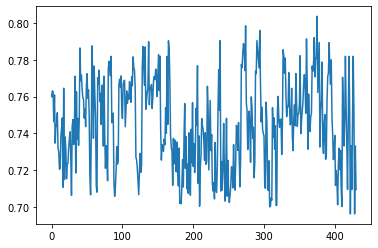

In [314]:
plt.plot(cscores)

In [426]:
gzmin = 0.75 #0.3 #0.75 
gzmax = 2.2 #3.5 #1.2
#ogrid = Grid2D(grid_alpha =1, grid_res = 0.05)
alpha = 1.05
z_slices = [(gzmin,gzmax)]
multimap = grid.MultiGrid(
    beams=z_slices, grid_alpha=alpha, slice_z=True, localize=False
)
#for nid in range(len(node_poses)):
for nid in range(last_nid +1):
    #pose = temp_poses[nid]
    pose = oposes[nid] + np.array([0,0,np.pi/2])
    fr_id = insertion_fr_ids[nid]
    ts, frame = lpb.get_frame(fr_id)
    frame = np.copy(frame[:, :6]).astype(np.float64)
    frame = frame[(frame[:,4]>0) & (frame[:,4] < 60)]
    frame = multimap.split_frame(frame[:,:3])[0]
    #print(frame)
    #frame = frame[frame[:,4]>1]
    #frame = frame[(frame[:,2] > gzmin) & (frame[:,2] < gzmax)]
    frame_z = voxel_filter(frame[:,:3], voxel_size=0.05)
    multimap.insert_points([frame_z], pose)

In [409]:
ogrid.grid_alpha
multimap.maps[0].grid_alpha, ogrid.grid.dtype

(2, dtype('uint8'))

In [427]:
pruned = True
map_padding = 20
if pruned:
    print("Pruning the map..")
    grid_x_limit, grid_y_limit = get_prune_limits(multimap.maps[0], poses)
    multimap = prune_map(multimap, grid_x_limit, grid_y_limit)

Pruning the map..
xlimit (-10.620000000000001, 130.76) ylimits (-29.564758189514023, 169.89371210504976)
origin (531.0, 4575.0)
grid_xlimit [   0. 7068.], grid_ylimit [ 3097. 13069.]
Grid coordinates: Cropping [0, 7068, 3097, 13069]


(array([[3211.,    0.,    0., ...,    0.,    0.,    0.],
        [3211.,    0.,    0., ...,    0.,    0.,    0.],
        [3211.,    0.,    0., ...,    0.,    0.,    0.],
        ...,
        [3211.,    0.,    0., ...,    0.,    0.,    0.],
        [3211.,    0.,    0., ...,    0.,    0.,    0.],
        [3211.,    0.,    0., ...,    0.,    0.,    0.]]),
 array([  0. ,  24.6,  49.2,  73.8,  98.4, 123. , 147.6, 172.2, 196.8,
        221.4, 246. ]),
 <a list of 5722 BarContainer objects>)

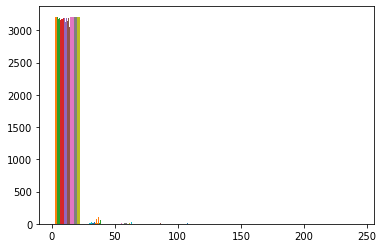

In [412]:
plt.hist(ogrid.grid)

254 246


(array([[8320.,    0.,    0., ...,    0.,    0.,    0.],
        [8320.,    0.,    0., ...,    0.,    0.,    0.],
        [8320.,    0.,    0., ...,    0.,    0.,    0.],
        ...,
        [8320.,    0.,    0., ...,    0.,    0.,    0.],
        [8320.,    0.,    0., ...,    0.,    0.,    0.],
        [8320.,    0.,    0., ...,    0.,    0.,    0.]]),
 array([  0. ,  25.4,  50.8,  76.2, 101.6, 127. , 152.4, 177.8, 203.2,
        228.6, 254. ]),
 <a list of 9973 BarContainer objects>)

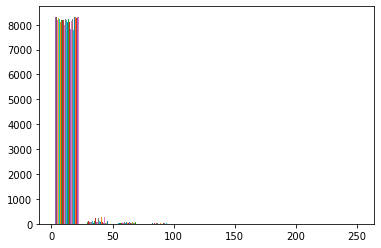

In [411]:
print(np.max(multimap.maps[0].grid), np.max(ogrid.grid))


plt.figure()
plt.hist(multimap.maps[0].grid)

In [401]:
%matplotlib inline

In [430]:
def plot_map(grid_map, alpha=1.0):
    x1, y1 = -grid_map.origin * grid_res
    x2, y2 = (grid_map.grid.shape - grid_map.origin) * grid_res
    gmap = grid_map.grid.copy()
    if grid_map.grid.dtype == np.uint8:
        max_val = min(255, np.max(grid_map.grid))
        #max_val = 128
        #gmap[gmap==0] = 255
        #gmap[gmap< 255] = 255- gmap[gmap<255]
    else:
        max_val = 1
    
    plt.imshow(
        max_val - grid_map.grid.T,
        #gmap.T,
        alpha=alpha,
        cmap="gray",
        origin="lower",
        extent=[x1, x2, y1, y2],
    )


In [434]:
len(insertion_fr_ids[:last_nid +1]) , len(oposes)

(10121, 10121)

In [ ]:
map_name = "/home/arindam/data/flipkart_gplus1/"
#%matplotlib notebook
#%matplotlib notebook
multimap.save_map(map_name)
np.save(f"{map_name}/yelli_poses.npy", oposes)
np.save(f"{map_name}/yelli_frames.npy", insertion_fr_ids[:last_nid +1])
with open(os.path.join(map_name, "map_metadata.json"), "w") as f:
    json.dump(generate_map_metadata(data_dir), f)
quality = map_quality(multimap.maps[0].grid)
print(f"map quality {quality}")


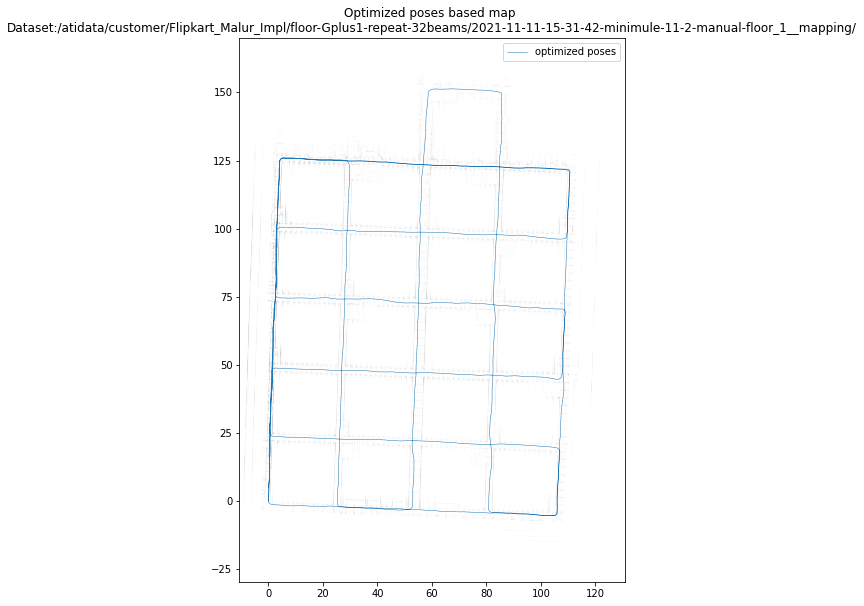

In [438]:


plt.figure(figsize=(10,10))
plot_map(multimap.maps[0], alpha=1)
#plot_map_new(ogrid, alpha=1.0)
#plt.plot(node_poses[:,0], node_poses[:,1], label = 'unoptimized poses')
#plt.plot(temp_poses[:,0], temp_poses[:,1], label = 'optimized poses')
plt.plot(oposes[:,0], oposes[:,1], linewidth = 0.5,label = 'optimized poses')
plt.legend()
plt.title(f"Optimized poses based map \nDataset:{dataset}")
#plt.xlim(40,60)
#plt.ylim(5, 30)
plt.savefig(f"{map_name}/yelli_map.png", dpi=1000, bbox_inches="tight")

In [299]:
submaps_nids =np.array([submap.node_ids[0] for submap in finished_submaps])
def dds(i, xlim, ylim):
    cons = constraints[i]
    sid = np.argwhere(submaps_nids ==cons.node_ids[0])[0][0]
    submap = finished_submaps[sid]
    nid = cons.node_ids[1]
    end_snid = finished_submaps[sid].node_ids[-1]
    if submap.iscompressed:
        submap.decompress_data()
    fr_id = insertion_fr_ids[nid]
    ts, fr = lpb.get_frame(fr_id)
    tr = cons.relative_pose 
    qtr = qe.get_quaternion_from_angle_axis(tr[2]-np.pi/2, np.array([0,0,1]))
    tfr = qe.rotate_pointcloud(qtr, fr[:,:3])+ np.array([tr[0], tr[1], 0])

    cpss = node_poses[cons.node_ids]   
    
    plt.figure(figsize = (20,10))
    plt.subplot(121)
    plot_map_new(submap.grid, alpha=2.0)
    plt.scatter(tfr[:,0], tfr[:,1], s=1)
    plt.xlim(tr[0]-xlim, tr[0] + xlim )
    plt.ylim(tr[1]-xlim, tr[1] + xlim)
    plt.title(f"Submap_id: {sid}, submap_node_id : {submap.node_ids[0]}, node_id:{nid}, cscore: {cscores[i]}")
    plt.subplot(122)
    plt.plot(node_poses[:,0], node_poses[:,1])
    plt.plot(cpss[:,0], cpss[:,1], 'o-', label = 'constraint')
    plt.plot(cpss[0,0], cpss[0,1], 'o', label = 'submap_node')
    if not submap.iscompressed:
        submap.compress_data()
interact(dds, i = IntSlider(min = 0, max=len(constraints)), xlim= FloatSlider(min=0.5, max=60, step = 0.5,value=10), 
         ylim = FloatSlider(min=0.5, max=60, step = 0.5, value=10))

interactive(children=(IntSlider(value=0, description='i', max=431), FloatSlider(value=10.0, description='xlim'…

<function __main__.dds(i, xlim, ylim)>

In [138]:
submaps_nids =np.array([submap.node_ids[0] for submap in finished_submaps])


In [189]:
%matplotlib inline
temp_poses = node_poses.copy()
def dis(i):
    temp_poses = dis.temp_poses
    cons = constraints[i]
    sid = np.argwhere(submaps_nids ==cons.node_ids[0])[0][0]
    submap = finished_submaps[sid]
    nid = cons.node_ids[1]
    end_snid = finished_submaps[sid].node_ids[-1]
    ps = PoseGraphOptimization()
    for i in range(0,submap.node_ids[-1] + 1 ):
    #for i in range(0,len(temp_poses)):
        pgpose = temp_poses[i].copy()

        pgpose[2] = normalize_pose(pgpose[2]- np.pi/2)
        if i == 0:                        
            ps.add_vertex(i, pgpose, fixed = True)
        else:
            ps.add_vertex(i, pgpose)
    print("max node added ",i)

    #for i in range(0,submap.node_ids[-1] + 1):
    #for i in range(0,nid+1):
    #for i in range(0,len(temp_poses)- 1):
    #    ps.add_edge_from_state([i,i+1], information=np.identity(3))
    for si in range(0, sid+1):
        si_nid = finished_submaps[si].node_ids[0]
        for ni in finished_submaps[si].node_ids[1:]:
            ps.add_edge_from_state([si_nid, ni], information= np.identity(3))

    print("si",si, "ni", ni)
    con_pose = cons.relative_pose
    con_pose[2] = normalize_pose(con_pose[2] - np.pi/2)
    ps.add_edge([submap.node_ids[0], nid], con_pose, information= np.identity(3))
    ps.optimize()

    tpose = temp_poses[submap.node_ids[-1]].copy()
    for ti in range(0, submap.node_ids[-1] + 1):
    #for ti in range(0, len(temp_poses[i])):
        temp_poses[ti] = ps.get_pose(ti).vector()
        temp_poses[ti,2] = normalize_pose(temp_poses[ti,2] + np.pi/2)
    print("ti", ti)
    apose = combine_yelli_poses(temp_poses[submap.node_ids[-1]], get_inverse_yelli_pose(tpose) )
    for ti in range(submap.node_ids[-1]+1, len(temp_poses)):
        #print(apose)
        #print(ti)
        temp_poses[ti] = combine_yelli_poses(apose, temp_poses[ti])
    print("ti", ti)
    cpss = node_poses[cons.node_ids]
    tcpss = temp_poses[cons.node_ids]
    
    plt.figure(figsize =(14,7))
    plt.subplot(121)
    plt.plot(node_poses[:,0], node_poses[:,1])
    plt.quiver(node_poses[:,0], node_poses[:,1], np.cos(node_poses[:,2]), np.sin(node_poses[:,2]))
    plt.plot(node_poses[:submap.node_ids[-1],0], node_poses[:submap.node_ids[-1],1])
    #plt.plot(temp_poses[:,0], node_poses[:,1])
    plt.plot(cpss[:,0],cpss[:,1], 'o-')
    plt.axis('equal')
    plt.title(f"cnids : {cons.node_ids}")
    plt.subplot(122)
    plt.plot(temp_poses[:,0], temp_poses[:,1])
    plt.quiver(temp_poses[:,0], temp_poses[:,1], np.cos(temp_poses[:,2]), np.sin(temp_poses[:,2]))
    plt.plot(temp_poses[:submap.node_ids[-1],0], temp_poses[:submap.node_ids[-1],1])
    plt.plot(tcpss[:,0],tcpss[:,1], 'o-')
    plt.axis('equal')
    dis.temp_poses = temp_poses
    
dis.temp_poses = temp_poses
interact(dis, i = IntSlider(min = 0, max = len(constraints)))

interactive(children=(IntSlider(value=0, description='i', max=62), Output()), _dom_classes=('widget-interact',…

<function __main__.dis(i)>

(-16.463034883176523,
 165.00049302214222,
 -61.901271460700976,
 134.98662043251852)

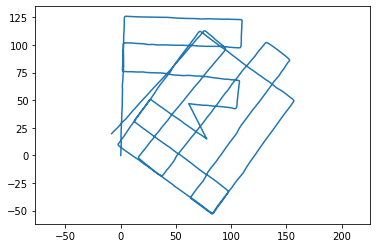

In [185]:
temp_poses = node_poses.copy()
a = np.array([1.3, 5, np.pi/3])
start = 3000
for i in range(start, len(temp_poses)):
    temp_poses[i] = combine_yelli_poses(a,temp_poses[i])

plt.plot(temp_poses[:,0], temp_poses[:,1])
plt.axis('equal')

(-0.08292990782003878,
 1.7415280642208144,
 -0.08430179921322217,
 1.0516334190101535)

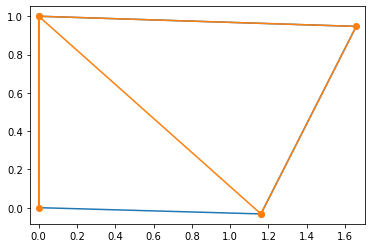

In [33]:
a = np.array([[0,0,0],
             [1,0,np.pi/2],
             [1, 1, np.pi],
             [0,1, 3 * np.pi/2],
             [0,0.15, 3*np.pi/2]])

constraints = [Constraint([1,2],np.array([2,3,0.1])),
               Constraint([3,0],np.array([2,1,0.3])),
              Constraint([3,1],np.array([2,1.1,0.3]))]

#a = node_poses.copy()

for j in range(len(constraints)):
    
    ps = PoseGraphOptimization()
   
    upto = max(constraints[j].node_ids)
    for i in range(upto+1):
        b = a[i]
        b[2] = normalize_pose(b[2])
        if i == 0:
            ps.add_vertex(i, b, fixed=True)
        else:
            ps.add_vertex(i, b)

    for i in range(upto):
         ps.add_edge_from_state([i,i+1], information=np.identity(3))
    #ps.add_edge([0, 4], np.array([0,0, 3*np.pi/2]), information= np.identity(3))

    c = constraints[j].relative_pose.copy()
    c[2] = normalize_pose(c[2] - np.pi/2)
    ps.add_edge(constraints[j].node_ids, c)

    ps.optimize()

    for i in range(upto):
        a[i] = ps.get_pose(i).vector()
        a[i,2] = normalize_pose(a[i,2] + np.pi/2)
    
# for i in range(len(constraints)):
#     c = constraints[i].relative_pose.copy()
#     c[2] = normalize_pose(c[2] - np.pi/2)
#     ps.add_edge(constraints[i].node_ids, c)

# ps.optimize()


# o=[]
# for i in range(len(a)):
#     o.append(ps.get_pose(i).vector())
    
# o = np.array(o)

an = np.concatenate([a[constraints[i].node_ids] for i in range(len(constraints))], axis = 0)


plt.figure()
plt.plot(a[:,0], a[:,1])
#plt.plot(o[:,0], o[:,1])
plt.plot(an[:,0], an[:,1], 'o-')
plt.axis('equal')

In [ ]:
class SubmapMultigrid:
    def __init__(self, pose, grid_res, grid_alpha, num_levels=4):
        self.pose = pose.copy()
        self.grid_alpha = grid_alpha
        self.grid_res = grid_res
        self.num_levels = num_levels
        self.grids = [Grid2D(self.grid_alpha, 2**i * self.grid_res ) for i in self.num_levels]
        self.num_insertions = 0
        self.finished = False
        self.node_ids = []
        self.frame_ids = []
        self.local_insertion_poses = None
        self.iscompressed = False
        
    def search(self, frame, x_search_window,y_search_window,angle_search_window,
               max_range = 60, score_th = score_th):
        hpose, hscores, hnum_visited = hierarchical_search(self.grids, spose_estimate, frame,
                                        x_search_window,y_search_window,angle_search_window
                                        , max_range = 60, score_th = score_th)
        return hpose,hscores, hnum_visited 
        #return self.grid.search(frame, search_space, count_once=count_once)
    
    def insert_points(self, frame, pose, frame_id, node_id):        
        if not self.finished:
            self.num_insertions +=1
            for i in range(self.num_levels):
                self.grids[i].insert_points(pose, frame)
            self.node_ids.append(node_id)
            self.frame_ids.append(frame_id)
            if self.local_insertion_poses is None:
                self.local_insertion_poses = pose.reshape(1,3)
            else:
                self.local_insertion_poses = np.concatenate((self.local_insertion_poses, pose.reshape(1,3)), axis = 0)
        else:
            print("Submap update is finished. Not inserting ")
            
    def finish(self):
        self.finished = True
        self.compress_data()
    
    def compress_data(self):
        cctx = zstandard.ZstdCompressor()
        for i in range(self.num_levels):
            self.grids[i] = pickle.dumps(self.grids[i])
            self.grids[i] = cctx.compress(self.grids[i])
        self.iscompressed = True
        
    def decompress_data(self):
        dctx = zstandard.ZstdDecompressor()
        for i in range(self.num_levels):            
            self.grids[i] = dctx.decompress(self.grids[i])
            self.grids[i] = pickle.loads(self.grids[i])
        self.iscompressed = False

In [95]:
imu_ts = [0.00667, 0.01]

f_range = 65
grid_res = 0.02
grid_alpha =1
num_submap_range_data = 90
alpha= 1.05
start_frame = 50

grid_params = {
    "x": (-0.1, 0.1),
#    "x": (-0.2, 0.2),
#    "x": (-0.4, 0.4),
#    "y": (-0.02, 0.30),
    "y": (-0.20, 0.30),
#    "y": (-0.40, 0.60),
    "theta": (-0.2, 0.2),
#    "num_x": 11,
#    "num_x": 22,
#    "num_x": 44,
#    "num_y": 17,
#    "num_y" : 26,
#    "num_y" : 52,
#    "num_t": 41,
    "num_t": 61,
    
}

grid_params['num_x'] = int((grid_params['x'][1] - grid_params['x'][0])/grid_res + 1)
grid_params['num_y'] = int((grid_params['y'][1] - grid_params['y'][0])/grid_res + 1)


zmin = 0.3
zmax = 2.0

array([[ 7.80073557e+01, -1.30596901e-01, -1.61645449e+00],
       [ 7.22410846e+01, -3.80043139e+00, -6.12382973e-02],
       [ 7.80073557e+01, -1.30596901e-01, -1.61645449e+00],
       [ 7.24618869e+01, -3.79430176e+00, -6.16126392e-02],
       [ 7.80073557e+01, -1.30596901e-01, -1.61645449e+00],
       [ 7.25618456e+01, -3.80007881e+00, -6.17108545e-02],
       [ 7.80073557e+01, -1.30596901e-01, -1.61645449e+00],
       [ 7.26617107e+01, -3.80583078e+00, -5.56043292e-02],
       [ 7.80073557e+01, -1.30596901e-01, -1.61645449e+00],
       [ 7.27814781e+01, -3.81240544e+00, -5.68443149e-02],
       [ 7.80073557e+01, -1.30596901e-01, -1.61645449e+00],
       [ 7.30211151e+01, -3.82593512e+00, -5.26619690e-02],
       [ 7.80073557e+01, -1.30596901e-01, -1.61645449e+00],
       [ 7.32208145e+01, -3.83737946e+00, -5.43158253e-02],
       [ 7.80073557e+01, -1.30596901e-01, -1.61645449e+00],
       [ 7.35792266e+01, -3.87603374e+00, -4.65392051e-02],
       [ 7.80073557e+01, -1.30596901e-01

In [95]:
num_grid_levels = 4
x_search_window = (-1,1)
y_search_window = (-1,1)
angle_search_window = (-0.2, 0.2)
score_th = 0.5

max_frames = 75000 
data_dir = dataset
imu_data = load_data(data_dir)
ts = np.mean(np.diff(imu_data.time))
dt = imu_ts[np.argmin(np.abs(imu_ts - ts))]
#imu_tracker = ImuTracker(dt)
imu_tracker = ImuTracker()
imu_bias_initialized = False
i = 0
print(f"")
while not imu_bias_initialized:
    imu_bias_initialized = imu_tracker.get_initial_gyro_bias(imu_data.iloc[i])
    i += 1
best_scores, poses, frame_list = [], [], []
submaps = []

z_slices = [(zmin,zmax)]

print("Using Z slices:", z_slices)

#pose = np.array([[0, 0, np.pi / 2 + tilt]] * len(z_slices))
pose = np.array([0.,0., np.pi/2])
prev_pose = pose.copy()

active_submaps = []
finished_submaps = []

spose = pose
#spose = np.array([1,2,0])
submap = SubmapMultigrid(spose.copy(), grid_res, grid_alpha, num_levels = num_grid_levels )
active_submaps.append(submap)

node_poses = []
insertion_fr_ids=[]

count_once = True

i, frame_id = 0, -1
debug_data_dir = data_dir
bootstrap_frames =20
try:
    lpb = lidar_pb.LidarSmallPb(data_dir)
except:
    lpb = lidar_pb.LidarPb(data_dir)
prev_frame_time, prev_frame = lpb.get_frame(start_frame - 2)

num_frames = np.minimum(len(lpb.list_frames()), max_frames)
print(f"total frames {num_frames}")
filtered_pts = []
for frame_id in range(start_frame, num_frames - 1):
    #if frame_id % 2 != 0:
        #continue
    try:
        frame_time, frame = lpb.get_frame(frame_id)
    except:
        print(f"skipping {frame_id}. divide-by-zero error")
        continue

    frame = np.copy(frame[:, :6]).astype(np.float64)
#     if use_16_beams:
#         ##### fix for 32 beams
#         frame = frame.reshape(-1,2048,6)
#         if frame.shape[0] == 32:
#             # select any 16 beams
#             beams = [1,3,5,7,9,11,13,15,17,19,21,23,25,27,29,31]
#             frame = frame[beams]
#         frame = frame.reshape(-1,6)
#         ##### fix for 32 beams

#     if correct_roll_pitch:
#         frame, roll, pitch = lidar_utils.correct_tilt(
#             frame, roll, pitch, lidar_ht=lidar_ht, use_cuda=use_cuda
#         )
#         if abs(roll) > 0.05 or abs(pitch) > 0.05:
#             print(f"Warning: Roll {roll:.2f}, Pitch  {pitch:0.2f}")

    frame = frame[(frame[:,4]>0) & (frame[:,4] < 60)]
    frame = frame[(frame[:,2] > zmin) & (frame[:,2] < zmax)]
    
    #filtered_frame = voxel_filter(frame, voxel_size=0.05)
    filtered_frame,_ = voxel_filter_fast(voxel_filter(frame, voxel_size=0.05), trunc=False, voxel = 0.25)
    #filtered_frame_z = multimap.split_frame(filtered_frame)
    
    frame_z = voxel_filter(frame[:,:3], voxel_size=0.05)

    
    #filtered_pts.append(filtered_frame_z[0].shape[0])

    if frame_id < start_frame + bootstrap_frames:
        #multimap.insert_points(filtered_frame_z, pose[0])
        #print("pose", pose, frame_z.shape)
        print("Num Bootstrap insertions", active_submaps[0].num_insertions)
        spose = combine_yelli_poses(pose, get_inverse_yelli_pose(active_submaps[0].pose))
        node_poses.append(pose)
        insertion_fr_ids.append(frame_id)
        active_submaps[0].insert_points(frame_z, spose, frame_id, node_id = len(node_poses)-1 )
        frame_list.append(frame_id)
        poses.append(pose)
        prev_insert_ts = frame_time
        prev_frame_time, prev_frame = frame_time, frame
        last_inserted_pose = pose.copy()
        continue
    
    prev_wid = lidar_wheel_inds[frame_id-1]
    present_wid = lidar_wheel_inds[frame_id]
    is_moving, v, w = check_vehicle_motion(np.vstack((all_v[prev_wid:present_wid],all_w[prev_wid:present_wid])).T)
        
    if not is_moving:
        continue
    
    relevant_imu_data = imu_data[imu_data["time"].between(prev_frame_time, frame_time)]
    for imu_idx in range(relevant_imu_data.shape[0]):
        imu_tracker.add_imu_data(relevant_imu_data.iloc[imu_idx])

    pose_estimate = imu_pose_estimate(imu_tracker, frame_time, pose)
    spose_estimate = combine_yelli_poses(get_inverse_yelli_pose(active_submaps[0].pose),pose_estimate)
    #spose_estimate = imu_submap_pose_estimate(imu_tracker, frame_time, active_submaps[0].pose, pose)
    #print(frame_id,pose_estimate)
    #search_space = utils.grid_space(center=spose_estimate, **grid_params)
    #scores = multimap.search(filtered_frame_z, search_space)
    #print()
   
    hpose, hscores, hnum_visited = active_submaps[0].search(filtered_frame, x_search_window,y_search_window,angle_search_window,
               max_range = 60, score_th = score_th, count_once = count_once)
    #scores = scores/n_uni
     
    #print(scores)
    scores = hscores[-1]
    best = np.argmax(scores)
    #pose = [search_space[b] for b in best]
    #best_scores.append([scores[i][b] for i, b in enumerate(best)])
    best_scores.append(scores[best]/ hnum_visited[-1][best])
    #pose = select_best_pose(pose, best_scores[-1])
    
    if hpose is None:
        print(f"Score below threshold: {scores[best]/hnum_visited[-1][best]}")
        continue
    spose = hpose
    pose = combine_yelli_poses(active_submaps[0].pose, spose)
    
    if len(frame_z) < 500:
        continue
    #Check all quadrants have points
    if (np.sum((frame_z[:,0] < 0) & (frame_z[:,1] > 0)) <10) or \
    (np.sum((frame_z[:,0] < 0) & (frame_z[:,1] < 0)) <10) or \
    (np.sum((frame_z[:,0] > 0) & (frame_z[:,1] > 0)) <10) or \
    (np.sum((frame_z[:,0] > 0) & (frame_z[:,1] < 0)) <10):
        continue
    #print(pose)
    #if (np.linalg.norm(pose[:2]-prev_pose[:2])> 0.1 or (prev_insert_ts - frame_time)>1) :
    if (np.linalg.norm(pose[:2]-last_inserted_pose[:2])> 0.15 or (prev_insert_ts - frame_time)>1) :
        #multimap.insert_points(filtered_frame_z, pose[0])
        #multimap.insert_points(frame_z, pose[0])
        
        #print("Num insertions", active_submaps[0].num_insertions)
        #print("Fr id", frame_id)
        #print("sub pose", active_submaps[0].pose)
        node_poses.append(pose)
        insertion_fr_ids.append(frame_id)
        active_submaps[0].insert_points(frame_z, spose, frame_id, node_id=len(node_poses)-1)
        if len(active_submaps) ==1:
            
            if active_submaps[0].num_insertions >= int(num_submap_range_data/2):
                active_submaps.append(SubmapMultigrid(pose.copy(), grid_res, grid_alpha, num_levels = num_grid_levels))
                s2pose = combine_yelli_poses(get_inverse_yelli_pose(active_submaps[1].pose),pose)
                active_submaps[1].insert_points(frame_z,s2pose, frame_id, node_id=len(node_poses)-1)
                #print(f"spose {spose}, s2pose {s2pose}")
                
        else:
            
            s2pose = combine_yelli_poses(get_inverse_yelli_pose(active_submaps[1].pose),pose)
            active_submaps[1].insert_points(frame_z,s2pose, frame_id, node_id=len(node_poses)-1)
            #print(f"len else spose {spose}, s2pose {s2pose}")
            
        if active_submaps[0].num_insertions >= num_submap_range_data - 1:
            active_submaps[0].finish() 
            finished_submaps.append(active_submaps.pop(0))
            active_submaps.append(SubmapMultigrid(pose.copy(), grid_res, grid_alpha, num_levels=num_grid_levels))
            s2pose = combine_yelli_poses(get_inverse_yelli_pose(active_submaps[1].pose), pose)
            active_submaps[1].insert_points(frame_z,s2pose, frame_id, node_id=len(node_poses)-1)
        
        #print("num active submaps", len(active_submaps))
        prev_insert_ts = frame_time
        last_inserted_pose = pose.copy()
    #multimap.insert_points(filtered_frame_z, pose[0])
     
    prev_pose = pose.copy()
    frame_list.append(frame_id)    
    poses.append(pose)
    if frame_id % 250 == 0:
        print(
            f"frame:{frame_id} scores:{best_scores[-1]} best pose:{pose}  "
        )
    prev_frame_time, prev_frame = frame_time, frame

#multimap.transform_scores()
poses = np.array(poses)
node_poses = np.array(node_poses)
insertion_fr_ids = np.array(insertion_fr_ids)

print(f"final pose {poses[-1]}")
#print(f"Min points in frame: {np.min(filtered_pts)}")
# if pruned:
#     print("Pruning the map..")
#     grid_x_limit, grid_y_limit = get_prune_limits(multimap.maps[0], poses)
#     multimap = prune_map(multimap, grid_x_limit, grid_y_limit)
# if not save_as_float:
#     multimap.maps[0].grid = (multimap.maps[0].grid * 128).astype(np.uint8)
#     multimap.maps[0].origin.dtype = "float"
# multimap.save_map(map_name)
# np.save(f"{map_name}/yelli_poses.npy", poses)
# np.save(f"{map_name}/yelli_frames.npy", frame_list)
# with open(os.path.join(map_name, "map_metadata.json"), "w") as f:
#     json.dump(generate_map_metadata(data_dir), f)
# quality = map_quality(multimap.maps[0].grid)
# print(f"map quality {quality}")
# alpha_arr = [1.0, 0.7]



Text(0.5, 1.0, 'origin [2712. 4713.]')

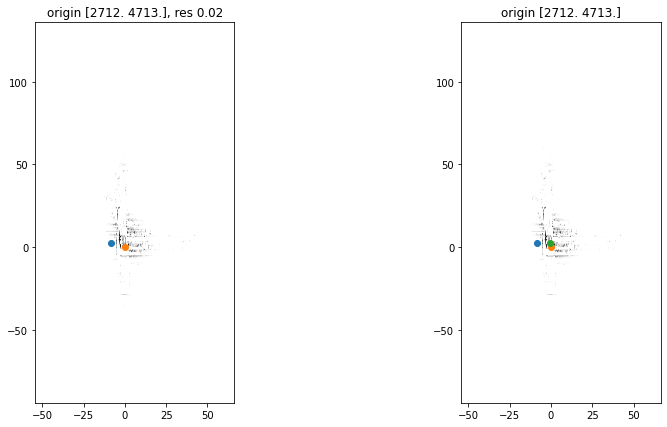

In [256]:
import g2o

In [221]:
sm = Submap(active_submaps[1].pose, grid_res, grid_alpha)
#sm = Submap(np.array([1,1.1,np.pi/3]), grid_res, grid_alpha)
#for i in range(1250, len(poses)):
def dis(i):
    fr_id= frame_list[i]
    pose = poses[i]
    ts, frame = lpb.get_frame(fr_id)
    frame = np.copy(frame[:, :6]).astype(np.float64)
    frame = frame[(frame[:,4]>0) & (frame[:,4] < 60)]
    frame = frame[(frame[:,2] > zmin) & (frame[:,2] < zmax)]
    frame_z = voxel_filter(frame[:,:3], voxel_size=0.05)
    spose = combine_yelli_poses( get_inverse_yelli_pose(sm.pose), pose)
    sm.insert_points(frame_z, spose )
    
    plt.figure(figsize=(10,10))
    plt.imshow(1 - (sm.grid.grid.T>0), cmap='gray')
    plt.title(f"i {i}")
interact(dis, i=IntSlider(min = 1250, max=len(poses)))

interactive(children=(IntSlider(value=1250, description='i', max=1448, min=1250), Output()), _dom_classes=('wi…

<function __main__.dis(i)>

In [77]:
s = set()
s.add((1,2))
s.add((2,1))
s.add((3,4))
(1,2) in s

True

In [279]:




def get_beam_indices(all_vertical_angles , beam_angle, rtol = 0.0001):
    bi = np.isclose(all_vertical_angles, beam_angle, rtol = 0.0001)
    return bi

@numba.jit(nopython = True)
def get_vertical_angles_numba(all_vertical_angles, rtol = 0.0001):
    vertical_angles = []
    v_ = all_vertical_angles
    v_temp = v_.copy()
    for angle in v_:
        #sim_bool_ind = np.isclose(v_temp, angle, rtol = rtol)
        sim_bool_ind = np.fabs(v_temp - angle) < rtol
        if np.sum(sim_bool_ind) > 0:
            vertical_angles.append(v_temp[sim_bool_ind][0])
            v_temp = v_temp[np.logical_not(sim_bool_ind)]
    return np.array(vertical_angles)

@numba.jit(nopython=True)
def get_slopes_vbeams(sorted_vbeams, ground_origin, hangle_search_bound = 0.002):
    beam0 = sorted_vbeams[0]
    slope_mat = np.nan * np.ones((sorted_vbeams.shape[0],sorted_vbeams.shape[1]))
    num_beam_pts = sorted_vbeams.shape[1]
    num_beams = sorted_vbeams.shape[0]
    #print(num_beam_pts, num_beams, slope_mat.shape)
    for i in range(num_beam_pts):
        vpt0 = ground_origin
        vpt1 = beam0[i]
        han = vpt1[-1]
        seg = vpt1[:3] - vpt0
        slope = np.arctan2(seg[2], np.linalg.norm(seg[:2]))
        vpt0 = vpt1
        slope_mat[0, i] = slope
        for bi in range(num_beams-1):
            beam_i = bi +1
            beam = sorted_vbeams[beam_i]
            
            ind = get_inds_horizontal_angles(beam[:,-1], han, search_bound = hangle_search_bound)
            #print(bi,ind)
            if len(ind) != 1: 
                break
            vpt1 = beam[ind[0]]
            han = vpt1[-1]
            if vpt1[4] == 0:
                slope = 0
            else:    
                seg = vpt1 - vpt0
                slope = np.arctan2(seg[2], np.linalg.norm(seg[:2]))
                vpt0 = vpt1
            #print(bi,ind)
            slope_mat[beam_i, ind[0]] = slope
            
    return slope_mat
            
@numba.jit(nopython = True)
def get_inds_horizontal_angles(horizontal_angles, search_angle, search_bound = 0.002):
    """Horizontal angles must be in the range (0,2pi)"""
    lower_limit = (search_angle - search_bound) #% (2*np.pi)
    upper_limit = (search_angle + search_bound) #% (2*np.pi)
    binds = np.zeros(len(horizontal_angles), dtype=np.bool_)
    if (lower_limit < 0) or (upper_limit > 2*np.pi):
        lower_limit = lower_limit % (2*np.pi)
        upper_limit = upper_limit % (2*np.pi)
        binds = (horizontal_angles > lower_limit) | (horizontal_angles < upper_limit)
    else:
        binds = (horizontal_angles > lower_limit) & (horizontal_angles < upper_limit)
    
    inds = find_where(binds)
    
    return inds
        
@numba.jit(nopython = True)
def find_where(bool_arr):   
    inds = []
    bool_arr = bool_arr.astype(np.bool_)
    num_ele = len(bool_arr)
    for i in range(num_ele):
        if bool_arr[i] == True:
            inds.append(i)

    inds = np.array(inds, dtype = np.uint32)
    return inds

def filter_by_slope(pts, ground_origin, slope_threshold = 80, hangle_search_bound = 0.002):
    """pts : n x 6 -> (x,y,z,v(in_deg), d, h(in rad))
       ground_origin : (0,0, -lidar_height)
       slope_threshold: in degrees
       hangle_search_bound: horizontal angle deviation in a vertical slice
    """
    pts[:,-1] = pts[:,-1] % (2*np.pi)
    al_v = get_vertical_angles_numba(pts[:,3])
    al_v.sort()
    beam_ids = [get_beam_indices(pts[:,3],al_v[i]) for i in range(len(al_v))]
    vbeams = np.array([pts[beam_ids[i]] for i in range(len(beam_ids))])
    slope_mat = get_slopes_vbeams(vbeams, ground_origin, hangle_search_bound)
    slope_arr = slope_mat.reshape(-1)
    pts = np.array(vbeams).reshape(-1,6)
    sl_th = np.deg2rad(slope_threshold)
    sl_mask = slope_arr > sl_th
    sl_pts = pts[sl_mask]
    return sl_pts

#Usage
#sl_pts = filter_by_slope(pts, ground_origin, slope_threshold = 85)

In [292]:
#def ds(i):
i = 200
def ds(i):
    ts, fr = lpb.get_frame(i)

    fr_f = filter_by_slope(fr[:,:6], ground_origin= np.array([0,0,-0.55]),  slope_threshold = 85)
    plt.figure(figsize=(14,7))
    plt.subplot(121)
    plt.scatter(fr[:,0], fr[:,1], s=1)
    plt.scatter(fr_f[:,0], fr_f[:,1], s=1)
    plt.axis('equal')
    plt.xlim(-5,5)
    plt.ylim(-5,5)
    plt.title(f"Frame_id: {i}")
    plt.subplot(122)
    plt.scatter(fr_f[:,0], fr_f[:,1], s=1)
    plt.xlim(-5,5)
    plt.ylim(-5,5)
interact(ds, i = IntSlider(min = 10, max=lpb.num_frames(), step = 10))

interactive(children=(IntSlider(value=10, description='i', max=27638, min=10, step=10), Output()), _dom_classe…

<function __main__.ds(i)>

In [35]:
@numba.jit(nopython = True)
def odds(probability):
    return probability/(1-probability)

@numba.jit(nopython = True)
def prob_from_odds(odds_val):
    return odds_val/(1+ odds_val)


In [49]:
a= (np.random.rand(100000) * 255).astype(int)
%timeit prob_from_odds(a)

107 µs ± 105 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [48]:
a= (np.random.rand(100000) * 255).astype(int)
a

array([136,  77, 209, ..., 243,  99,  43])